## Imports and Data Loading

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.utils import resample
import scipy
from numpy.fft import fft
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.feature_selection import SelectKBest, chi2
np.random.seed(8055)

In [61]:
# load data
hr = pd.read_csv('data/alpaca_hr.csv')
resp = pd.read_csv('data/alpaca_resp.csv')
sao2 = pd.read_csv('data/alpaca_sao2.csv')

hr['offset'] = hr['offset'] / 60
resp['offset'] = resp['offset'] / 60
sao2['offset'] = sao2['offset'] / 60

gcs = pd.read_csv('data/patient_motor.csv')
gcs = gcs[gcs['observationoffset'] > -1]
gcs['observationoffset'] = gcs['observationoffset'] / 60
final_gcs_id = gcs.groupby('patientunitstayid')['observationoffset'].transform(max) == gcs['observationoffset']

final_gcs = gcs[final_gcs_id]
display(final_gcs['Value'].isna().sum())

#display(hr)
#display(resp)
#display(sao2)

0

In [63]:
print(final_gcs)

        patientunitstayid  observationoffset    Key  Value          origin
0                  172448           2.500000  Motor    1.0  nurse_charting
31                 242714          46.850000  Motor    6.0  nurse_charting
40                 242825          12.733333  Motor    6.0  nurse_charting
45                 243176          54.566667  Motor    6.0  nurse_charting
86                 243493          59.033333  Motor    6.0  nurse_charting
93                 244161          23.200000  Motor    6.0  nurse_charting
96                 245210          38.016667  Motor    6.0  nurse_charting
102                247522          77.633333  Motor    5.0  nurse_charting
129                247722          39.750000  Motor    6.0  nurse_charting
132                248373          30.750000  Motor    6.0  nurse_charting
181                249742          39.516667  Motor    6.0  nurse_charting
183                249872          17.083333  Motor    6.0  nurse_charting
185                250392

# Lab Data

In [4]:
# Loading lab data
lab = pd.read_csv('data/lab_data.csv')
lab = lab.loc[lab['labresultoffset'] > -1]
lab = lab.loc[lab['labresultoffset'] <= 24*60]
display(lab)
labtypes = list(lab['labname'].drop_duplicates())

,Unnamed: 0,patientunitstayid,diagnosisstring,labid,patientunitstayid.1,labresultoffset,labtypeid,labname,labresult,labresulttext,labmeasurenamesystem,labmeasurenameinterface,labresultrevisedoffset
14,14,976143,burns/trauma|trauma - CNS|spinal cord injury|c...,231365792,976143,1259,4.0,bedside glucose,106.00,106,mg/dL,mg/dL,1259
82,82,2896749,neurologic|trauma - CNS|intracranial injury,653612385,2896749,534,3.0,PTT,31.40,31.4,sec,sec,534
87,87,2896749,neurologic|trauma - CNS|intracranial injury,669448807,2896749,534,3.0,Hct,36.70,36.7,%,%,534
107,107,2896749,neurologic|trauma - CNS|intracranial injury,648051805,2896749,1059,2.0,Vancomycin - trough,16.70,16.7,mcg/mL,ug/mL,1059
131,131,2896749,neurologic|trauma - CNS|intracranial injury,648754398,2896749,534,3.0,PT,14.60,14.6,sec,sec,534
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2374604,374604,962326,neurologic|trauma - CNS|intracranial injury|wi...,228891620,962326,294,1.0,total protein,5.10,5.1,g/dL,g/dL,342
2374608,374608,962326,neurologic|trauma - CNS|intracranial injury|wi...,228891619,962326,294,1.0,bicarbonate,23.00,23,mmol/L,mmol/L,342
2374610,374610,962326,neurologic|trauma - CNS|intracranial injury|wi...,228891613,962326,294,1.0,alkaline phos.,60.00,60,Units/L,IU/L,342
2374612,374612,962326,neurologic|trauma - CNS|intracranial injury|wi...,228891612,962326,294,1.0,creatinine,1.25,1.250,mg/dL,mg/dL,342


In [5]:
# Getting table of averages over first 24 hours
l = labtypes[0]
labtypedata = lab[lab['labname'] == l]
labtypedata_avgs = labtypedata.groupby('patientunitstayid').mean()['labresult']
labtypedata_avgs = labtypedata_avgs.to_frame()
labtypedata_avgs = labtypedata_avgs.reset_index()
labtypedata_avgs =labtypedata_avgs.rename(columns = {'labresult':l})
for l in labtypes[1:]:
    labtypedata = lab[lab['labname'] == l]
    labtypedata_avgs1 = labtypedata.groupby('patientunitstayid').mean()['labresult']
    labtypedata_avgs1 = labtypedata_avgs1.to_frame()
    labtypedata_avgs1 = labtypedata_avgs1.reset_index()
    labtypedata_avgs1 =labtypedata_avgs1.rename(columns = {'labresult':l})
    labtypedata_avgs = labtypedata_avgs.merge(labtypedata_avgs1, how='outer', on='patientunitstayid')

In [6]:
labtypedata_avgs = labtypedata_avgs[labtypedata_avgs.columns[labtypedata_avgs.isnull().mean() < 0.2]]
#labtypedata_avgs.head()

In [7]:
lab_avgs_map = {}
for l in labtypes:
    if l in labtypedata_avgs.columns:
        col = list(labtypedata_avgs[l].dropna())
        if len(col) != 0:
            avg = sum(col)/len(col)
            lab_avgs_map[l] = avg
        else:
            labtypedata_avgs = labtypedata_avgs.drop(columns=l)
# print(lab_avgs_map)

In [8]:
# Filling in na values for labtypedata_avgs.columns with averages
# for that column
for l in labtypedata_avgs.columns:
    if l != 'patientunitstayid':
        col = labtypedata_avgs[l]
        labtypedata_avgs[l] = col.fillna(lab_avgs_map[l])
#labtypedata_avgs.head()

In [9]:
# Getting table of measurement counts over first 24 hours
l = labtypes[0]
labtypedata = lab[lab['labname'] == l]
labtypedata_cts = labtypedata.groupby('patientunitstayid').count()['labresult']
labtypedata_cts = labtypedata_cts.to_frame()
labtypedata_cts = labtypedata_cts.reset_index()
labtypedata_cts =labtypedata_cts.rename(columns = {'labresult':l})
for l in labtypes[1:]:
    labtypedata = lab[lab['labname'] == l]
    labtypedata_cts1 = labtypedata.groupby('patientunitstayid').count()['labresult']
    labtypedata_cts1 = labtypedata_cts1.to_frame()
    labtypedata_cts1 = labtypedata_cts1.reset_index()
    labtypedata_cts1 =labtypedata_cts1.rename(columns = {'labresult':l})
    labtypedata_cts = labtypedata_cts.merge(labtypedata_cts1, how='outer', on='patientunitstayid')

In [10]:
labtypedata_cts = labtypedata_cts[labtypedata_cts.columns[labtypedata_cts.isnull().mean() < 0.2]]
labtypedata_cts = labtypedata_cts.apply(lambda x: x.fillna(x.median()),axis=0)

In [11]:
#print(labtypedata_cts.median())
labtypedata_cts = labtypedata_cts > labtypedata_cts.median()
#labtypedata_cts.head(20)

# Demographic Data

In [12]:
# Loading demographic data
demographic_all = pd.read_csv('data/patient_demographics_data.csv')

#demographic_all.head()

died = demographic_all.loc[:, ['patientunitstayid', 'unitdischargestatus']]
died['alive'] = died['unitdischargestatus'] == 'Alive'
died = died.drop_duplicates()
display(died)

,patientunitstayid,unitdischargestatus,alive
0,2896749,Alive,True
1,976143,Alive,True
2,1823818,Alive,True
3,2715079,Alive,True
4,1015921,Alive,True
...,...,...,...
9405,2263791,Alive,True
9406,174499,Alive,True
9407,1480007,Alive,True
9408,962326,Alive,True


In [13]:
demographic_all.head()

,Unnamed: 0,patientunitstayid,diagnosisstring,patientunitstayid.1,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,...,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid
0,0,2896749,neurologic|trauma - CNS|intracranial injury,2896749,2350019,Male,29,NaN,397,971,...,Emergency Department,1,admit,70.00,NaN,07:34:00,10378,Floor,Alive,027-95634
1,1,976143,burns/trauma|trauma - CNS|spinal cord injury|c...,976143,719568,Female,35,African American,181,428,...,Emergency Department,1,admit,77.10,84.1,18:24:00,2273,Telemetry,Alive,007-505
2,2,1823818,burns/trauma|trauma - CNS|intracranial injury|...,1823818,1435627,Male,85,Caucasian,281,687,...,Direct Admit,1,admit,84.40,84.4,18:13:00,2552,Floor,Alive,018-23662
3,3,2715079,neurologic|trauma - CNS|intracranial injury|wi...,2715079,2181711,Male,72,Caucasian,388,962,...,Emergency Department,1,admit,71.66,NaN,00:53:00,6003,Other External,Alive,027-103254
4,4,1015921,neurologic|trauma - CNS|intracranial injury|wi...,1015921,750929,Female,> 89,Caucasian,188,451,...,Other Hospital,1,admit,60.90,60.9,16:12:00,4907,Skilled Nursing Facility,Alive,008-35721


In [13]:
#for col in demographic_all.columns:
#    print(col)

# Keeping the following columns (numerical for now):
to_keep=['patientunitstayid', 'gender', 'age', 'ethnicity', 'admissionheight', 'admissionweight']
# to_keep=['age', 'admissionheight', 'admissionweight', 'patientunitstayid']
demographic = demographic_all[to_keep]
#demographic.head()
#print(demographic.dtypes)

In [15]:
demographic = demographic.replace('> 89', 90)
#demographic.head()

In [16]:
genders = list(demographic['gender'])
male = []
female = []
other = []
for g in genders:
    if g == 'Male':
        male.append(1)
        female.append(0)
        other.append(0)
    elif g == 'Female':
        male.append(0)
        female.append(1)
        other.append(0)
    else:
        male.append(0)
        female.append(0)
        other.append(1)
demographic['Male'] = male
demographic['Female'] = female
demographic['Other_Gender'] = other
demographic.head()

,patientunitstayid,gender,age,ethnicity,admissionheight,admissionweight,Male,Female,Other_Gender
0,2896749,Male,29,NaN,172.7,70.00,1,0,0
1,976143,Female,35,African American,157.5,77.10,0,1,0
2,1823818,Male,85,Caucasian,182.8,84.40,1,0,0
3,2715079,Male,72,Caucasian,177.8,71.66,1,0,0
4,1015921,Female,90,Caucasian,162.5,60.90,0,1,0


In [17]:
ethnicities = list(demographic['ethnicity'])
af_am = []
cauc = []
other = []
hisp = []
asian = []
nat_am = []
for e in ethnicities:
    if e == 'African American':
        af_am.append(1)
        cauc.append(0)
        hisp.append(0)
        asian.append(0)
        nat_am.append(0)
        other.append(0)
    elif e == 'Caucasian':
        af_am.append(0)
        cauc.append(1)
        hisp.append(0)
        asian.append(0)
        nat_am.append(0)
        other.append(0)
    elif e == 'Hispanic':
        af_am.append(0)
        cauc.append(0)
        hisp.append(1)
        asian.append(0)
        nat_am.append(0)
        other.append(0)
    elif e == 'Asian':
        af_am.append(0)
        cauc.append(0)
        hisp.append(0)
        asian.append(1)
        nat_am.append(0)
        other.append(0)
    elif e == 'Native American':
        af_am.append(0)
        cauc.append(0)
        hisp.append(0)
        asian.append(0)
        nat_am.append(1)
        other.append(0)
    else:
        af_am.append(0)
        cauc.append(0)
        hisp.append(0)
        asian.append(0)
        nat_am.append(0)
        other.append(1)
demographic['af_am'] = af_am
demographic['caucasian'] = cauc
demographic['hisp'] = hisp
demographic['asian'] = asian
demographic['nat_am'] = nat_am
demographic['other_nat'] = other
demographic.head()

,patientunitstayid,gender,age,ethnicity,admissionheight,admissionweight,Male,Female,Other_Gender,af_am,caucasian,hisp,asian,nat_am,other_nat
0,2896749,Male,29,NaN,172.7,70.00,1,0,0,0,0,0,0,0,1
1,976143,Female,35,African American,157.5,77.10,0,1,0,1,0,0,0,0,0
2,1823818,Male,85,Caucasian,182.8,84.40,1,0,0,0,1,0,0,0,0
3,2715079,Male,72,Caucasian,177.8,71.66,1,0,0,0,1,0,0,0,0
4,1015921,Female,90,Caucasian,162.5,60.90,0,1,0,0,1,0,0,0,0


In [18]:
demographic = demographic.drop(columns = ['gender', 'ethnicity'])
demographic.head()

,patientunitstayid,age,admissionheight,admissionweight,Male,Female,Other_Gender,af_am,caucasian,hisp,asian,nat_am,other_nat
0,2896749,29,172.7,70.00,1,0,0,0,0,0,0,0,1
1,976143,35,157.5,77.10,0,1,0,1,0,0,0,0,0
2,1823818,85,182.8,84.40,1,0,0,0,1,0,0,0,0
3,2715079,72,177.8,71.66,1,0,0,0,1,0,0,0,0
4,1015921,90,162.5,60.90,0,1,0,0,1,0,0,0,0


In [192]:
demographic = demographic.astype(float)
print(demographic.shape)

(9410, 13)


In [20]:
#print(hr['value'].isna().sum())

In [21]:
# NOTE: Need to do this SEPARATELY for train/val/test
# deal with nan
interplim = 1000
#hr = hr.groupby('patientunitstayid').apply(lambda group: group.interpolate(method='linear', limit = interplim))
#resp = resp.groupby('patientunitstayid').apply(lambda group: group.interpolate(method='linear', limit = interplim))
#sao2 = sao2.groupby('patientunitstayid').apply(lambda group: group.interpolate(method='linear', limit = interplim))

#for now drop Nan rows (shouldn't be many)...
hr = hr.dropna()
resp = resp.dropna()
sao2 = sao2.dropna()

#display(hr.loc[hr['patientunitstayid'] == 143274])

# Medication Data

In [22]:
# Loading medication data
medication_all = pd.read_csv('data/medication_data_long_query.csv')

medication_all.head()

/home/adit/.virtualenvs/pcm/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,medicationid,patientunitstayid,drugorderoffset,drugstartoffset,drugivadmixture,drugordercancelled,drugname,drughiclseqno,dosage,...,prn,drugstopoffset,gtc,diagnosisid,patientunitstayid.1,activeupondischarge,diagnosisoffset,diagnosisstring,icd9code,diagnosispriority
0,0,74966496,2283908,94,93,No,No,NaN,33442.0,NaN,...,No,93,0,27500797,2283908,True,43,burns/trauma|trauma - CNS|intracranial injury|...,"852.20, S06.5",Other
1,1,77239676,2283908,1589,1662,No,No,KLOR-CON,549.0,20 mEq,...,No,1758,59,27500797,2283908,True,43,burns/trauma|trauma - CNS|intracranial injury|...,"852.20, S06.5",Other
2,2,75347883,2283908,46,102,No,No,NaN,11639.0,NaN,...,No,109,35,27500797,2283908,True,43,burns/trauma|trauma - CNS|intracranial injury|...,"852.20, S06.5",Other
3,3,78285918,2283908,119,117,No,No,"HEPARIN (PORCINE) 1,000 UNIT/ML INJECTION : 10...",2810.0,"2,000 Units",...,No,8762,99,27500797,2283908,True,43,burns/trauma|trauma - CNS|intracranial injury|...,"852.20, S06.5",Other
4,4,80341125,2283908,5,-29,No,No,NARCAN,1874.0,0.1 mg,...,No,8762,9,27500797,2283908,True,43,burns/trauma|trauma - CNS|intracranial injury|...,"852.20, S06.5",Other


In [23]:
medtypes = list(medication_all['drugname'].drop_duplicates().dropna())
print(medtypes)

['KLOR-CON', 'HEPARIN (PORCINE) 1,000 UNIT/ML INJECTION : 10 ML VIAL', 'NARCAN', 'LOPRESSOR', 'Heparin', 'PROTONIX', 'APRESOLINE', 'NORCO', 'MILK OF MAGNESIA', 'ROCEPHIN', 'COLACE', 'SUBLIMAZE', 'DEXTROSE 5%-1/2 NORMAL SALINE IV : 1000 ML BAG', 'SODIUM CHLORIDE 0.9 % IV : 500 ML', 'LEVAQUIN', 'KLOR-CON,K-TAB', 'SODIUM CHLORIDE 0.9 % SYRINGE : 10 ML SYRINGE', 'MAGNESIUM SULFATE 2 GRAM/50 ML IV PIGGY BACK : 50 ML FLEX CONT', 'ZOFRAN', 'KEPPRA', 'TYLENOL', 'ONDANSETRON 2 MG/1 ML 2ML SDV INJ', 'SODIUM CHLORIDE 0.9% 1000 ML LVP', 'THIAMINE 100 MG TAB', 'PERCOCET 5/325 TAB', 'SODIUM CHLORIDE 0.9% 1000 ML PB', 'MAGNESIUM OXIDE 400 MG TAB', 'PANTOPRAZOLE 40 MG EC TAB', 'MORPHINE 2 MG/1 ML 1 ML SYR', 'MORPHINE 4 MG/1 ML 1 ML SYR', 'LORazepam 1 MG TAB', 'LORazepam 2 MG/1 ML 1 ML INJ', 'FOLIC ACID 1 MG TAB', 'BISACODYL 10 MG RECT SUPP', 'potassium CHLORIDE 20 MEQ TR TAB', 'LABETALOL 5 MG/1ML 20ML MDV INJ', 'acetaMINOPHEN 650MG RECT SUPP', 'LORazepam 0.5 MG TAB', 'POTASSIUM SODIUM PHOSPHATE PWDPKT

In [24]:
# Getting table of indicator variables for each patient
m = medtypes[0]
medtypedata = medication_all[medication_all['drugname'] == m][['patientunitstayid']].drop_duplicates()#, 'frequency']]
indicator = np.ones((medtypedata.shape[0], 1))
medtypedata[m] = indicator
# print(np.isnan(medtypedata['drugstartoffset']).any())
for m in medtypes[1:]:
    medtypedata1 = medication_all[medication_all['drugname'] == m][['patientunitstayid']].drop_duplicates()
    indicator = np.ones((medtypedata1.shape[0], 1))
    medtypedata1[m] = indicator
    medtypedata = medtypedata.merge(medtypedata1, how='outer', on='patientunitstayid')

In [25]:
medtypedata = medtypedata.fillna(0)
medtypedata.head()

,patientunitstayid,KLOR-CON,"HEPARIN (PORCINE) 1,000 UNIT/ML INJECTION : 10 ML VIAL",NARCAN,LOPRESSOR,Heparin,PROTONIX,APRESOLINE,NORCO,MILK OF MAGNESIA,...,Coumadin,potassium chloride crys er 20 meq po tbcr,DEXTROSE 50% ADULT,clopidogrel,INFUVITE IV INJ 10ML,REGULAR insulin,150 ml flex cont : sodium chloride 0.9 % iv soln,metoprolol tartrate 25 mg po tabs,2 ML - NITROPRUSSIDE SODIUM 25 MG/ML IV SOLN,SoluMedrol
0,2283908,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2133894,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2146777,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2276986,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2368137,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


1390
1390


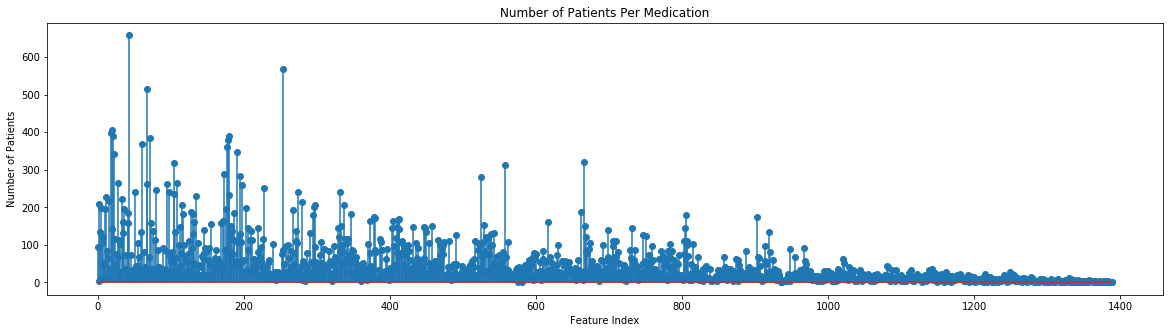

In [117]:
sums = medtypedata.sum(axis=0)
sums = np.asarray(list(sums[1:]))
print(len(list(medtypedata.columns[1:])))
print(len(sums))
plt.figure(figsize=(20,5))
plt.stem(sums)
plt.title('Number of Patients Per Medication')
plt.xlabel('Feature Index')
plt.ylabel('Number of Patients')
plt.show()

# Infusion Data

In [26]:
# Loading infusion data
infusion_all = pd.read_csv('data/infusion_data_long_query.csv')

infusion_all.head()

/home/adit/.virtualenvs/pcm/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,infusiondrugid,patientunitstayid,infusionoffset,drugname,drugrate,infusionrate,drugamount,volumeoffluid,patientweight,diagnosisid,patientunitstayid.1,activeupondischarge,diagnosisoffset,diagnosisstring,icd9code,diagnosispriority
0,0,38313443,1480738,478,Volume (mL)-sodium chloride 0.9 % bolus 250 mL...,250,NaN,NaN,NaN,NaN,21461764,1480738,True,62,burns/trauma|trauma - CNS|intracranial injury|...,"852.20, S06.5",Primary
1,1,36622948,1480738,413,Volume (mL)-sodium chloride 0.9 % bolus 250 mL...,250,NaN,NaN,NaN,NaN,21461764,1480738,True,62,burns/trauma|trauma - CNS|intracranial injury|...,"852.20, S06.5",Primary
2,2,36473945,1480738,33,Volume (mL)-sodium chloride 0.9 % bolus 250 mL...,250,NaN,NaN,NaN,NaN,21461764,1480738,True,62,burns/trauma|trauma - CNS|intracranial injury|...,"852.20, S06.5",Primary
3,3,12023288,892782,3205,Propofol (ml/hr),20.1,NaN,NaN,NaN,NaN,10741773,892782,False,2645,burns/trauma|trauma - CNS|intracranial injury|...,"852.00, S06.6",Primary
4,4,12253566,892782,3145,Fentanyl (ml/hr),2.5,NaN,NaN,NaN,NaN,10741773,892782,False,2645,burns/trauma|trauma - CNS|intracranial injury|...,"852.00, S06.6",Primary


In [27]:
infusiontypes = list(infusion_all['drugname'].drop_duplicates().dropna())
print(infusiontypes)

['Volume (mL)-sodium chloride 0.9 % bolus 250 mL (ml/hr)', 'Propofol (ml/hr)', 'Fentanyl (ml/hr)', 'Phenylephrine (ml/hr)', 'Cisatracurium IVF Infused (ml/hr)', 'Norepinephrine (ml/hr)', 'Mannitol IVF Infused (ml/hr)', 'Midazolam (ml/hr)', 'Vasopressin (ml/hr)', '3% Sodium Chloride IVF Infused (ml/hr)', 'Nicardipine (ml/hr)', 'Propofol (mcg/kg/min)', 'Nicardipine (mg/hr)', 'Lorazepam', 'Lorazepam (mg/hr)', 'Norepinephrine (mcg/min)', 'Propofol', 'Norepinephrine', 'NS (ml/hr)', 'LORazepam (Ativan) 100 mg Sodium Chloride 0.9% 100 ml  Premix (mg/hr)', 'Morphine 250 mg Sodium Chloride 0.9% 250 ml  Premix (mg/hr)', 'FentaNYL (Sublimaze) 2500 mcg Sodium Chloride 0.9% 250 ml  Premix (mcg/hr)', 'Dexmedetomidine(Precedex) 400 mcg Sodium Chloride 0.9% 100 ml (mcg/kg/hr)', 'Propofol (Diprivan) 1000 mg  100 ml  Premix (mcg/kg/min)', 'Vecuronium (Norcuron) 100 mg Sodium Chloride 0.9% 100 ml (mcg/kg/min)', 'D5/NS  (ml/hr)', 'NSS (ml/hr)', 'Octreotide (mcg/hr)', 'Diltiazem ()', 'epidural (ml/hr)', 'V

In [28]:
# Getting table of indicator variables for each patient
i = infusiontypes[0]
infusiontypedata = infusion_all[infusion_all['drugname'] == i][['patientunitstayid']].drop_duplicates()
indicator = np.ones((infusiontypedata.shape[0], 1))
infusiontypedata[i] = indicator
# print(np.isnan(medtypedata['drugstartoffset']).any())
for i in infusiontypes[1:]:
    infusiontypedata1 = infusion_all[infusion_all['drugname'] == i][['patientunitstayid']].drop_duplicates()
    indicator = np.ones((infusiontypedata1.shape[0], 1))
    infusiontypedata1[i] = indicator
    infusiontypedata = infusiontypedata.merge(infusiontypedata1, how='outer', on='patientunitstayid')

In [29]:
infusiontypedata = infusiontypedata.fillna(0)
infusiontypedata.head()

,patientunitstayid,Volume (mL)-sodium chloride 0.9 % bolus 250 mL (ml/hr),Propofol (ml/hr),Fentanyl (ml/hr),Phenylephrine (ml/hr),Cisatracurium IVF Infused (ml/hr),Norepinephrine (ml/hr),Mannitol IVF Infused (ml/hr),Midazolam (ml/hr),Vasopressin (ml/hr),...,Nitroprusside (),Pantoprazole (mg/kg/hr),Nitroglycerin (),Prbc (ml/hr),D30W/85 meq KCL/60 units insulin (ml/hr),Isoproterenol (),Lidocaine (),Haldol (mg/hr),D5LRKCL (ml/hr),1.8% saline (ml/hr)
0,1480738,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1495894,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,892782,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2117101,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1082629,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


420
420


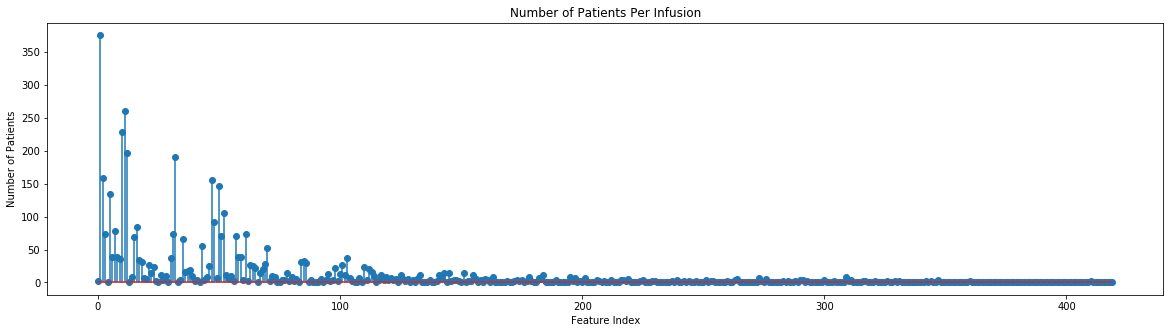

In [119]:
sums = infusiontypedata.sum(axis=0)
sums = np.asarray(list(sums[1:]))
print(len(list(infusiontypedata.columns[1:])))
print(len(sums))
plt.figure(figsize=(20,5))
plt.stem(sums)
plt.title('Number of Patients Per Infusion')
plt.xlabel('Feature Index')
plt.ylabel('Number of Patients')
plt.show()

## Set Parameters

In [30]:
# prediction frequency refers to the frequency with which we want to predict GCS
prediction_freq = 2

# summarization interval refers to the spacing between edges of the bins of our histogram (for summarizing physiology)
summarization_int = 0.8

## Bin data

In [31]:
# split data into bins based on summarization_int
bins=np.arange(25, step=summarization_int)
hr['offset_bin'] = pd.cut(hr['offset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
#display(hr[hr['patientunitstayid'] == 318676])
hr_grouped = hr.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
#hr_grouped['patientunitstayid'] = hr_grouped['patientunitstayid'].astype(int)

resp['offset_bin'] = pd.cut(resp['offset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
resp_grouped = resp.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
#resp_grouped['patientunitstayid'] = resp_grouped['patientunitstayid'].astype(int)

sao2['offset_bin'] = pd.cut(sao2['offset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
sao2_grouped = sao2.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
#sao2_grouped['patientunitstayid'] = sao2_grouped['patientunitstayid'].astype(int)

gcs['offset_bin'] = pd.cut(gcs['observationoffset'], bins, labels=list(np.arange(bins.shape[0] - 1)))
gcs_grouped = gcs.groupby(['patientunitstayid', 'offset_bin']).mean().reset_index()
gcs_grouped['offset'] = gcs_grouped['observationoffset']
gcs_grouped['value'] = gcs_grouped['Value']
gcs_grouped = gcs_grouped.drop(['observationoffset', 'Value'], axis = 1)
#gcs_grouped['patientunitstayid'] = gcs_grouped['patientunitstayid'].astype(int)

## Plot Samples

/home/adit/.virtualenvs/pcm/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


Text(0.5, 1.0, 'Motor GCS')

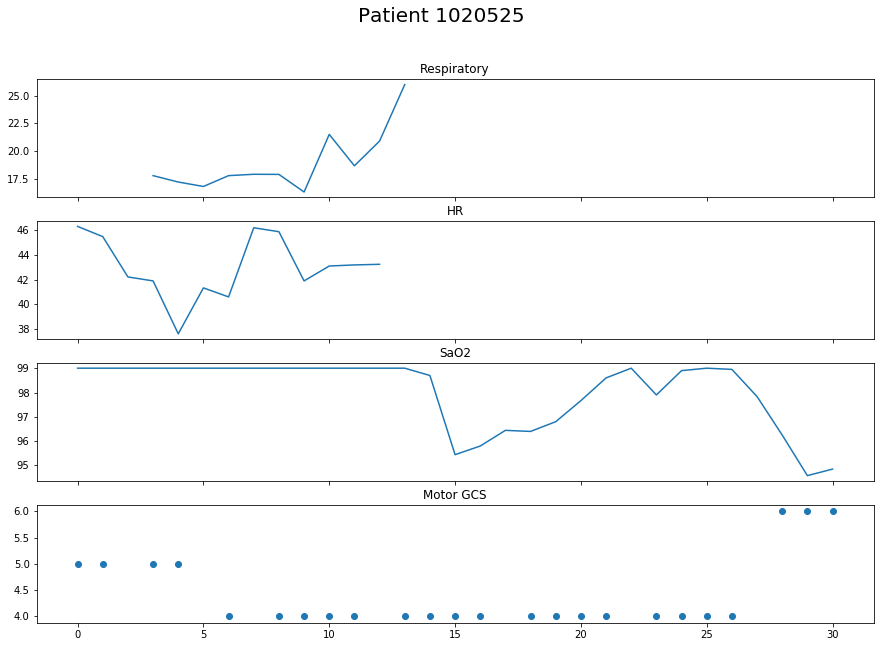

In [32]:
# get one patient's data
ind_slice = np.argwhere(hr_grouped['patientunitstayid'] == 1020525).flatten()
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(15,10))
f.suptitle("Patient 1020525", size = 20)
ax1.plot(np.arange(resp_grouped[resp_grouped.index.isin(ind_slice)]['value'].shape[0]),
         resp_grouped[resp_grouped.index.isin(ind_slice)]['value'])
ax1.set_title("Respiratory")

ax2.plot(np.arange(hr_grouped[hr_grouped.index.isin(ind_slice)]['value'].shape[0]),
         hr_grouped[hr_grouped.index.isin(ind_slice)]['value'])
ax2.set_title("HR")

ax3.plot(np.arange(sao2_grouped[sao2_grouped.index.isin(ind_slice)]['value'].shape[0]),
         sao2_grouped[sao2_grouped.index.isin(ind_slice)]['value'])
ax3.set_title("SaO2")

ax4.scatter(gcs_grouped[gcs_grouped.index.isin(ind_slice)]['offset_bin'], gcs_grouped[gcs_grouped.index.isin(ind_slice)]['value'])
ax4.set_title("Motor GCS")

## Prepare Datasets

In [33]:
# interpolate signal
hr_first24 = hr_grouped.copy()
resp_first24 = resp_grouped.copy()
sao2_first24 = sao2_grouped.copy()
gcs_first24 = gcs_grouped.copy()

hr_first24['value'] = hr_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']
resp_first24['value'] = resp_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']
sao2_first24['value'] = sao2_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']
gcs_first24['value'] = gcs_grouped.groupby('patientunitstayid').apply(lambda x: x['value'].interpolate(method='linear')).reset_index()['value']

In [34]:
# get first 24 hrs
myInt = 24.0 / summarization_int

hr_first24 = hr_first24.loc[hr_first24['offset_bin'] < myInt].drop(columns=['offset', 'offset_bin'])
resp_first24 = resp_first24.loc[resp_first24['offset_bin'] < myInt].drop(columns=['offset', 'offset_bin'])
sao2_first24 = sao2_first24.loc[sao2_first24['offset_bin'] < myInt].drop(columns=['offset', 'offset_bin'])
gcs_first24 = gcs_first24.loc[gcs_first24['offset_bin'] < myInt].drop(columns=['offset', 'offset_bin'])

# fill remaining na fields (beginning of patient stay if any) with overall signal mean (maybe median itf?)
hr_first24['value'] = hr_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(method='bfill'))
resp_first24['value'] = resp_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(method='bfill'))
sao2_first24['value'] = sao2_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(method='bfill'))
gcs_first24['value'] = gcs_first24.groupby('patientunitstayid').transform(lambda x: x.fillna(method='bfill'))

#hr_first24['value'] = hr_first24.groupby('patientunitstayid').transform(lambda x: x.median())
#resp_first24['value'] = resp_first24.groupby('patientunitstayid').transform(lambda x: x.median())
#sao2_first24['value'] = sao2_first24.groupby('patientunitstayid').transform(lambda x: x.median())
#gcs_first24['value'] = gcs_first24.groupby('patientunitstayid').transform(lambda x: x.median())

#display(resp_first24)
#display(sao2_first24)

In [35]:
further_exclusion = hr_first24.loc[hr_first24.isna()['value']]['patientunitstayid'].unique()
further_exclusion = np.hstack([further_exclusion, resp_first24.loc[resp_first24.isna()['value']]['patientunitstayid'].unique()])
further_exclusion = np.hstack([further_exclusion, sao2_first24.loc[sao2_first24.isna()['value']]['patientunitstayid'].unique()])
further_exclusion = np.hstack([further_exclusion, gcs_first24.loc[gcs_first24.isna()['value']]['patientunitstayid'].unique()])
further_exclusion = np.unique(further_exclusion)
#print(further_exclusion.shape)

In [36]:
# organize by patient

# first grab all the patient ids

# ISSUE: some patients are not represented, need to think of how to include them, perhaps -1?
keys1, keys2, keys3, keys4 = hr['patientunitstayid'].unique(), resp['patientunitstayid'].unique(), sao2['patientunitstayid'].unique(), final_gcs['patientunitstayid'].unique()
keys = []
for k in keys1:
    if (k in keys2) and (k in keys3) and (k in keys4) and (k not in further_exclusion):
        keys.append(k)

# now stack data based on the same patient order
X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
        None] for g in keys])

X_hr = X_hr.T
X_resp = X_resp.T
X_sao2 = X_sao2.T
X_gcs = X_gcs.T
#print(X_gcs)

# Modeling

In [36]:
# SET PARAMETERS

# number of pca components to extract
num_components = 40

# number of fourier features to extract
num_fourier_components = 40

# choose resampling technique
resampling = 'over'

# select model family
model_family = 'logistic'

In [37]:
id_df = pd.DataFrame(keys, columns =['patientunitstayid'])
# id_df.head()
labtypedata_cts_allids = labtypedata_cts.merge(id_df, how='right', on='patientunitstayid')
labtypedata_cts_allids = labtypedata_cts_allids.fillna(0)
#print(labtypedata_cts_allids.shape)
labtypedata_cts_allids.head()

,patientunitstayid,Hct,Hgb,MCV,RBC,platelets x 1000,WBC x 1000,MCHC,RDW,chloride,sodium,glucose,calcium,bicarbonate,creatinine,BUN,potassium
0,172448,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,242714,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,242825,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,243176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,243493,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
labtypedata_avgs_allids = labtypedata_avgs.merge(id_df, how='right', on='patientunitstayid')
#print(labtypedata_avgs_allids.shape)
for l in labtypedata_avgs_allids.columns:
    if l != 'patientunitstayid':
        col = labtypedata_avgs_allids[l]
        labtypedata_avgs_allids[l] = col.fillna(lab_avgs_map[l])
# labtypedata_avgs_allids = labtypedata_avgs_allids.fillna(-1)
#labtypedata_avgs_allids.head()

In [193]:
dem_allids = demographic.merge(id_df, how='right', on='patientunitstayid')
dem_allids = dem_allids.drop_duplicates()
#print(dem_allids.shape)
dem_allids = dem_allids.fillna(dem_allids.mean())
print(dem_allids.shape)
# labtypedata_avgs_allids = labtypedata_avgs_allids.fillna(-1)
#dem_allids.head()

death = died.merge(id_df, how = 'right', on = 'patientunitstayid')
print(death.shape)
# death.head()
# deathstatus = death['alive'].values[:, np.newaxis]
# print(deathstatus)
# print(np.isnan(deathstatus).any())

(2248, 13)
(2248, 3)


In [40]:
medication_allids = medtypedata.merge(id_df, how='right', on='patientunitstayid')
print(medication_allids.shape)
# Filling in NA with 0
medication_allids = medication_allids.fillna(0)

medication_allids.head()

(2248, 1391)


,patientunitstayid,KLOR-CON,"HEPARIN (PORCINE) 1,000 UNIT/ML INJECTION : 10 ML VIAL",NARCAN,LOPRESSOR,Heparin,PROTONIX,APRESOLINE,NORCO,MILK OF MAGNESIA,...,Coumadin,potassium chloride crys er 20 meq po tbcr,DEXTROSE 50% ADULT,clopidogrel,INFUVITE IV INJ 10ML,REGULAR insulin,150 ml flex cont : sodium chloride 0.9 % iv soln,metoprolol tartrate 25 mg po tabs,2 ML - NITROPRUSSIDE SODIUM 25 MG/ML IV SOLN,SoluMedrol
0,2283908,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2133894,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2368137,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017632,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2246533,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
infusion_allids = infusiontypedata.merge(id_df, how='right', on='patientunitstayid')
print(infusion_allids.shape)
# Filling in NA with 0
infusion_allids = infusion_allids.fillna(0)

infusion_allids.head()

(2248, 421)


,patientunitstayid,Volume (mL)-sodium chloride 0.9 % bolus 250 mL (ml/hr),Propofol (ml/hr),Fentanyl (ml/hr),Phenylephrine (ml/hr),Cisatracurium IVF Infused (ml/hr),Norepinephrine (ml/hr),Mannitol IVF Infused (ml/hr),Midazolam (ml/hr),Vasopressin (ml/hr),...,Nitroprusside (),Pantoprazole (mg/kg/hr),Nitroglycerin (),Prbc (ml/hr),D30W/85 meq KCL/60 units insulin (ml/hr),Isoproterenol (),Lidocaine (),Haldol (mg/hr),D5LRKCL (ml/hr),1.8% saline (ml/hr)
0,1082629,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,789888,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,705339,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,849403,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,588720,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
labavg_cols = []
for c in labtypedata_avgs_allids.columns:
    if c != 'patientunitstayid':
        labavg_cols.append(c)
X_labavgs = np.hstack([labtypedata_avgs_allids.loc[labtypedata_avgs_allids['patientunitstayid'] == g][labavg_cols].values[:,
        None] for g in keys])[0]

labcts_cols = []
for c in labtypedata_cts_allids.columns:
    if c != 'patientunitstayid':
        labcts_cols.append(c)
X_labcts = np.hstack([labtypedata_cts_allids.loc[labtypedata_cts_allids['patientunitstayid'] == g][labcts_cols].values[:,
        None] for g in keys])[0]

dem_cols = []
for c in dem_allids.columns:
    if c != 'patientunitstayid':
        dem_cols.append(c)
X_dem = np.hstack([dem_allids.loc[dem_allids['patientunitstayid'] == g][dem_cols].values[:,None] for g in keys])[0]

In [43]:
death.head()

,patientunitstayid,unitdischargestatus,alive
0,1823818,Alive,True
1,1015921,Alive,True
2,2228330,Alive,True
3,3073401,Alive,True
4,3199652,Alive,True


In [44]:
# Re-ordering the death mortality columns based on patientunitstayid
death_cols = ['alive']
deathstatus = np.hstack([death.loc[death['patientunitstayid'] == g][death_cols].values[:,None] for g in keys])[0]
print(deathstatus)

[[False]
 [ True]
 [ True]
 ...
 [ True]
 [ True]
 [ True]]


In [45]:
medication_cols = []
for c in medication_allids.columns:
    if c != 'patientunitstayid':
        medication_cols.append(c)
X_med = np.hstack([medication_allids.loc[medication_allids['patientunitstayid'] == g][medication_cols].values[:,None] for g in keys])[0]

infusion_cols = []
for c in infusion_allids.columns:
    if c != 'patientunitstayid':
        infusion_cols.append(c)
X_infusion = np.hstack([infusion_allids.loc[infusion_allids['patientunitstayid'] == g][infusion_cols].values[:,None] for g in keys])[0]

In [46]:
# Aligning final GCS with mortality
id_df.head()
final_gcs_finalids = final_gcs.merge(id_df, on='patientunitstayid', how='right')
died_finalids = died.merge(id_df, on='patientunitstayid', how='right')
print(final_gcs_finalids.shape)
print(np.isnan(final_gcs_finalids['Value']).any())
print(died_finalids.shape)
print(np.isnan(died_finalids['alive']).any())

# Merging the final_gcs_finalids and died_finalids based on patientunitstayid
gcs_mortality_comb = final_gcs_finalids.merge(died_finalids, on='patientunitstayid')[['patientunitstayid','Value','alive']]
gcs_mortality_comb.rename(columns={'Value':'final_gcs'}, inplace=True)
# display(gcs_mortality_comb)

# Finding patients that died and have GCS=6
died_gcs6 = gcs_mortality_comb[gcs_mortality_comb['final_gcs'] == 6.0]
died_gcs6 = died_gcs6[died_gcs6['alive'] == False]
display(died_gcs6.head())
died_gcs6_ids = list(died_gcs6['patientunitstayid'])
print(died_gcs6_ids)

(2248, 5)
False
(2248, 3)
False


,patientunitstayid,final_gcs,alive
258,649154,6.0,False
707,1126464,6.0,False
766,1207532,6.0,False
992,1722741,6.0,False
1167,1856344,6.0,False


[649154, 1126464, 1207532, 1722741, 1856344, 3084733, 3110966, 3206128, 3227462, 3234234]


# Feature Selection using Lasso Regression

In [159]:
mort = False
discard_dead = True

if mort and discard_dead:
    raise ValueError('invalid option')

if (not mort) and (discard_dead):
    # Removing the patients who have GCS = 6 and died
    newkeys = []
    for k in keys:
        if k not in died_gcs6_ids:
            newkeys.append(k)

    target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
            None] for g in newkeys])

        # now stack data based on the same patient order
    X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_hr = X_hr.T
    X_resp = X_resp.T
    X_sao2 = X_sao2.T
    X_gcs = X_gcs.T
    
    labavg_cols = []
    for c in labtypedata_avgs_allids.columns:
        if c != 'patientunitstayid':
            labavg_cols.append(c)
    X_labavgs = np.hstack([labtypedata_avgs_allids.loc[labtypedata_avgs_allids['patientunitstayid'] == g][labavg_cols].values[:,
            None] for g in newkeys])[0]

    labcts_cols = []
    for c in labtypedata_cts_allids.columns:
        if c != 'patientunitstayid':
            labcts_cols.append(c)
    X_labcts = np.hstack([labtypedata_cts_allids.loc[labtypedata_cts_allids['patientunitstayid'] == g][labcts_cols].values[:,
            None] for g in newkeys])[0]

    dem_cols = []
    for c in dem_allids.columns:
        if c != 'patientunitstayid':
            dem_cols.append(c)
    X_dem = np.hstack([dem_allids.loc[dem_allids['patientunitstayid'] == g][dem_cols].values[:,None] for g in newkeys])[0]

    medication_cols = []
    for c in medication_allids.columns:
        if c != 'patientunitstayid':
            medication_cols.append(c)
    X_med = np.hstack([medication_allids.loc[medication_allids['patientunitstayid'] == g][medication_cols].values[:,None] for g in newkeys])[0]

    infusion_cols = []
    for c in infusion_allids.columns:
        if c != 'patientunitstayid':
            infusion_cols.append(c)
    X_infusion = np.hstack([infusion_allids.loc[infusion_allids['patientunitstayid'] == g][infusion_cols].values[:,None] for g in newkeys])[0]

else:
        # now stack data based on the same patient order
    X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_hr = X_hr.T
    X_resp = X_resp.T
    X_sao2 = X_sao2.T
    X_gcs = X_gcs.T
    
    labavg_cols = []
    for c in labtypedata_avgs_allids.columns:
        if c != 'patientunitstayid':
            labavg_cols.append(c)
    X_labavgs = np.hstack([labtypedata_avgs_allids.loc[labtypedata_avgs_allids['patientunitstayid'] == g][labavg_cols].values[:,
            None] for g in keys])[0]

    labcts_cols = []
    for c in labtypedata_cts_allids.columns:
        if c != 'patientunitstayid':
            labcts_cols.append(c)
    X_labcts = np.hstack([labtypedata_cts_allids.loc[labtypedata_cts_allids['patientunitstayid'] == g][labcts_cols].values[:,
            None] for g in keys])[0]

    dem_cols = []
    for c in dem_allids.columns:
        if c != 'patientunitstayid':
            dem_cols.append(c)
    X_dem = np.hstack([dem_allids.loc[dem_allids['patientunitstayid'] == g][dem_cols].values[:,None] for g in keys])[0]

    medication_cols = []
    for c in medication_allids.columns:
        if c != 'patientunitstayid':
            medication_cols.append(c)
    X_med = np.hstack([medication_allids.loc[medication_allids['patientunitstayid'] == g][medication_cols].values[:,None] for g in keys])[0]

    infusion_cols = []
    for c in infusion_allids.columns:
        if c != 'patientunitstayid':
            infusion_cols.append(c)
    X_infusion = np.hstack([infusion_allids.loc[infusion_allids['patientunitstayid'] == g][infusion_cols].values[:,None] for g in keys])[0]

    target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
            None] for g in keys])

scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_gcs)
X_gcs_pca = raw_pca.transform(scaler.fit_transform(X_gcs))

scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_med)
X_med_pca = raw_pca.transform(scaler.fit_transform(X_med))

scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_infusion)
X_infusion_pca = raw_pca.transform(scaler.fit_transform(X_infusion))

pca_time = True
if pca_time:
    raw_pca = PCA(n_components = 5)
    raw_pca.fit(X_hr)
    X_hr_pca = raw_pca.transform(scaler.fit_transform(X_hr))
    raw_pca.fit(X_resp)
    X_resp_pca = raw_pca.transform(scaler.fit_transform(X_resp))
    raw_pca.fit(X_sao2)
    X_sao2_pca = raw_pca.transform(scaler.fit_transform(X_sao2))   

else:
    X_hr_pca = np.hstack([np.mean(X_hr, axis = 1)[:, np.newaxis], np.std(X_hr, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis],
                      np.std(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis]])

    X_resp_pca = np.hstack([np.mean(X_resp, axis = 1)[:, np.newaxis], np.std(X_resp, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis],
                      np.std(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis]])

    X_sao2_pca = np.hstack([np.mean(X_sao2, axis = 1)[:, np.newaxis], np.std(X_sao2, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis],
                        np.std(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis]])

X_phys = np.hstack([X_hr_pca, X_resp_pca, X_sao2_pca, X_gcs_pca])
X_phys = scaler.fit_transform(X_phys)

X_labdem = np.hstack([X_med, X_infusion])
X_naive = X_labdem

# split data
if mort:
    trainX, testX, trainY, testY = train_test_split(X_naive, deathstatus, test_size=0.3, random_state = 8055)
    trainY, testY = trainY.flatten(), testY.flatten()
else:
    trainX, testX, trainY, testY = train_test_split(X_naive, target_gcs, test_size=0.3, random_state = 8055)
    trainY, testY = trainY.flatten(), testY.flatten()

# resample
if resampling == 'over':
    if mort:
        positive = np.argwhere(trainY.flatten() == False).flatten()
        negative = np.argwhere(trainY.flatten() == True).flatten()
    else:
        positive = np.argwhere(trainY.flatten() < 6).flatten()
        negative = np.argwhere(trainY.flatten() == 6).flatten()
    
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_positive = resample(X_positive, replace=True, n_samples=X_negative.shape[0], random_state = 8055)
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]

elif resampling == 'under':
    if mort:
        positive = np.argwhere(trainY.flatten() == False).flatten()
        negative = np.argwhere(trainY.flatten() == True).flatten()
    else:
        positive = np.argwhere(trainY.flatten() < 6).flatten()
        negative = np.argwhere(trainY.flatten() == 6).flatten()
        
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_negative = resample(X_negative, replace=False, n_samples=X_positive.shape[0], random_state = 8055)
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]

In [146]:
# modify labels
if mort:
    testY_mod = testY.astype(int)
#     testY_mod[testY == False] = 0
#     testY_mod[testY == True] = 1

    trainY_mod = trainY.astype(int)
#     trainY_mod = trainY.copy()
#     trainY_mod[trainY ==False] = 0
#     trainY_mod[trainY == True] = 1
else:
    testY_mod = testY.copy()
    testY_mod[testY < 6] = 1
    testY_mod[testY == 6] = 0

    trainY_mod = trainY.copy()
    trainY_mod[trainY < 6] = 1
    trainY_mod[trainY == 6] = 0
    
# train feature-selector
clf = LogisticRegression(max_iter=2000, penalty='l1', l1_ratio=0.5,
                         solver='saga', C=.05)

print(trainX.shape)
clf.fit(trainX, trainY_mod)
print("Train Score:", clf.score(trainX, trainY_mod))

(2444, 1810)


C:\Users\owner\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


Train Score: 0.7074468085106383


In [147]:
lasso_coeff = clf.coef_[0]
print('Total columns: ' + str(len(lasso_coeff)))
lasso_indices = [x[0] for x in np.argwhere(clf.coef_[0] != 0).tolist()]
print('Indices of concatenated medication and infusion columns: ' + str(lasso_indices))
print(len(lasso_indices))
print(X_labdem.shape)
X_med_infusion_selected = X_labdem[:,lasso_indices]
print(X_med_infusion_selected.shape)

# getting column names
med_inf_colnames = list(medication_cols) + list(infusion_cols)
# print(med_inf_colnames)
selected_meds = np.asarray(med_inf_colnames)[lasso_indices]
print(selected_meds)
for m in selected_meds:
    print(m)

Total columns: 1810
Indices of concatenated medication and infusion columns: [67, 89, 95, 182, 206, 227, 254, 296, 316, 325, 332, 373, 432, 558, 562, 732, 796, 948, 1393, 1395, 1401, 1402, 1405, 1440]
24
(2238, 1810)
(2238, 24)
['ACETAMINOPHEN' 'CHLORHEXIDINE GLUCONATE UD LIQ 15ML'
 'acetaMINOPHEN 325 MG TAB' 'DIPRIVAN' 'CHLORHEXIDINE GLUCONATE 0.12%'
 'FAMOTIDINE' 'PANTOPRAZOLE SODIUM 40 MG IV SOLR' 'LORazepam'
 'SODIUM CHLORIDE 0.9% 1,000 ML BAG'
 'PIPERACILLIN SOD-TAZOBACTAM SO 3-0.375 G IV SOLR'
 'LEVETIRACETAM 500 MG/5ML IV SOLN' 'ATIVAN' 'FAMOTIDINE 20 MG TAB'
 'LEVETIRACETAM 500 MG PO TABS' 'LISINOPRIL'
 'INSULIN REGULAR HUMAN 100 UNIT/ML IJ SOLN' 'GLYCOPYRROLATE'
 'CALCIUM GLUCONATE 10 % IV SOLN' 'Phenylephrine (ml/hr)'
 'Norepinephrine (ml/hr)' 'Propofol (mcg/kg/min)' 'Nicardipine (mg/hr)'
 'Norepinephrine (mcg/min)' 'Insulin (units/hr)']
ACETAMINOPHEN
CHLORHEXIDINE GLUCONATE UD LIQ 15ML
acetaMINOPHEN 325 MG TAB
DIPRIVAN
CHLORHEXIDINE GLUCONATE 0.12%
FAMOTIDINE
PANTOPRAZOLE SO

# Alternatively, Computing P-Values

In [195]:
print(X_dem)

[[ 53.   177.8   96.4  ...   0.     0.     1.  ]
 [ 78.   182.9   89.2  ...   0.     0.     0.  ]
 [ 49.   193.04 102.05 ...   0.     1.     0.  ]
 ...
 [ 22.   175.3   77.3  ...   0.     0.     0.  ]
 [ 69.   165.1   81.   ...   0.     0.     0.  ]
 [ 79.   167.6   65.   ...   0.     0.     0.  ]]


In [212]:
mort = False
discard_dead = True

if mort and discard_dead:
    raise ValueError('invalid option')

if (not mort) and (discard_dead):
    # Removing the patients who have GCS = 6 and died
    newkeys = []
    for k in keys:
        if k not in died_gcs6_ids:
            newkeys.append(k)

    target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
            None] for g in newkeys])

        # now stack data based on the same patient order
    X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_hr = X_hr.T
    X_resp = X_resp.T
    X_sao2 = X_sao2.T
    X_gcs = X_gcs.T
    
    labavg_cols = []
    for c in labtypedata_avgs_allids.columns:
        if c != 'patientunitstayid':
            labavg_cols.append(c)
    X_labavgs = np.hstack([labtypedata_avgs_allids.loc[labtypedata_avgs_allids['patientunitstayid'] == g][labavg_cols].values[:,
            None] for g in newkeys])[0]

    labcts_cols = []
    for c in labtypedata_cts_allids.columns:
        if c != 'patientunitstayid':
            labcts_cols.append(c)
    X_labcts = np.hstack([labtypedata_cts_allids.loc[labtypedata_cts_allids['patientunitstayid'] == g][labcts_cols].values[:,
            None] for g in newkeys])[0]

    dem_cols = []
    for c in dem_allids.columns:
        if c != 'patientunitstayid':
            dem_cols.append(c)
    X_dem = np.hstack([dem_allids.loc[dem_allids['patientunitstayid'] == g][dem_cols].values[:,None] for g in newkeys])[0]

    medication_cols = []
    for c in medication_allids.columns:
        if c != 'patientunitstayid':
            medication_cols.append(c)
    X_med = np.hstack([medication_allids.loc[medication_allids['patientunitstayid'] == g][medication_cols].values[:,None] for g in newkeys])[0]

    infusion_cols = []
    for c in infusion_allids.columns:
        if c != 'patientunitstayid':
            infusion_cols.append(c)
    X_infusion = np.hstack([infusion_allids.loc[infusion_allids['patientunitstayid'] == g][infusion_cols].values[:,None] for g in newkeys])[0]

else:
        # now stack data based on the same patient order
    X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_hr = X_hr.T
    X_resp = X_resp.T
    X_sao2 = X_sao2.T
    X_gcs = X_gcs.T
    
    labavg_cols = []
    for c in labtypedata_avgs_allids.columns:
        if c != 'patientunitstayid':
            labavg_cols.append(c)
    X_labavgs = np.hstack([labtypedata_avgs_allids.loc[labtypedata_avgs_allids['patientunitstayid'] == g][labavg_cols].values[:,
            None] for g in keys])[0]

    labcts_cols = []
    for c in labtypedata_cts_allids.columns:
        if c != 'patientunitstayid':
            labcts_cols.append(c)
    X_labcts = np.hstack([labtypedata_cts_allids.loc[labtypedata_cts_allids['patientunitstayid'] == g][labcts_cols].values[:,
            None] for g in keys])[0]

    dem_cols = []
    for c in dem_allids.columns:
        if c != 'patientunitstayid':
            dem_cols.append(c)
    X_dem = np.hstack([dem_allids.loc[dem_allids['patientunitstayid'] == g][dem_cols].values[:,None] for g in keys])[0]

    medication_cols = []
    for c in medication_allids.columns:
        if c != 'patientunitstayid':
            medication_cols.append(c)
    X_med = np.hstack([medication_allids.loc[medication_allids['patientunitstayid'] == g][medication_cols].values[:,None] for g in keys])[0]

    infusion_cols = []
    for c in infusion_allids.columns:
        if c != 'patientunitstayid':
            infusion_cols.append(c)
    X_infusion = np.hstack([infusion_allids.loc[infusion_allids['patientunitstayid'] == g][infusion_cols].values[:,None] for g in keys])[0]

    target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
            None] for g in keys])

scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_gcs)
X_gcs_pca = raw_pca.transform(scaler.fit_transform(X_gcs))

scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_med)
X_med_pca = raw_pca.transform(scaler.fit_transform(X_med))

scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_infusion)
X_infusion_pca = raw_pca.transform(scaler.fit_transform(X_infusion))

pca_time = True
if pca_time:
    raw_pca = PCA(n_components = 5)
    raw_pca.fit(X_hr)
    X_hr_pca = raw_pca.transform(scaler.fit_transform(X_hr))
    raw_pca.fit(X_resp)
    X_resp_pca = raw_pca.transform(scaler.fit_transform(X_resp))
    raw_pca.fit(X_sao2)
    X_sao2_pca = raw_pca.transform(scaler.fit_transform(X_sao2))   

else:
    X_hr_pca = np.hstack([np.mean(X_hr, axis = 1)[:, np.newaxis], np.std(X_hr, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis],
                      np.std(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis]])

    X_resp_pca = np.hstack([np.mean(X_resp, axis = 1)[:, np.newaxis], np.std(X_resp, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis],
                      np.std(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis]])

    X_sao2_pca = np.hstack([np.mean(X_sao2, axis = 1)[:, np.newaxis], np.std(X_sao2, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis],
                        np.std(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis]])

X_phys = np.hstack([X_hr_pca, X_resp_pca, X_sao2_pca, X_gcs_pca])
X_phys = scaler.fit_transform(X_phys)

# X_labdem = np.hstack([X_labavgs, X_labcts, X_dem, X_med, X_infusion])
X_labdem = np.hstack([X_labavgs])
X_naive = X_labdem

# split data
if mort:
    trainX, testX, trainY, testY = train_test_split(X_naive, deathstatus, test_size=0.3, random_state = 8055)
    trainY, testY = trainY.flatten(), testY.flatten()
else:
    trainX, testX, trainY, testY = train_test_split(X_naive, target_gcs, test_size=0.3, random_state = 8055)
    trainY, testY = trainY.flatten(), testY.flatten()

# resample
if resampling == 'over':
    if mort:
        positive = np.argwhere(trainY.flatten() == False).flatten()
        negative = np.argwhere(trainY.flatten() == True).flatten()
    else:
        positive = np.argwhere(trainY.flatten() < 6).flatten()
        negative = np.argwhere(trainY.flatten() == 6).flatten()
    
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_positive = resample(X_positive, replace=True, n_samples=X_negative.shape[0], random_state = 8055)
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]

elif resampling == 'under':
    if mort:
        positive = np.argwhere(trainY.flatten() == False).flatten()
        negative = np.argwhere(trainY.flatten() == True).flatten()
    else:
        positive = np.argwhere(trainY.flatten() < 6).flatten()
        negative = np.argwhere(trainY.flatten() == 6).flatten()
        
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_negative = resample(X_negative, replace=False, n_samples=X_positive.shape[0], random_state = 8055)
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]

In [213]:
# modify labels
if mort:
    testY_mod = testY.astype(int)
#     testY_mod[testY == False] = 0
#     testY_mod[testY == True] = 1

    trainY_mod = trainY.astype(int)
#     trainY_mod = trainY.copy()
#     trainY_mod[trainY ==False] = 0
#     trainY_mod[trainY == True] = 1
else:
    testY_mod = testY.copy()
    testY_mod[testY < 6] = 1
    testY_mod[testY == 6] = 0

    trainY_mod = trainY.copy()
    trainY_mod[trainY < 6] = 1
    trainY_mod[trainY == 6] = 0

In [214]:
# compare with statsmodels
import statsmodels.api as sm
sm_model = sm.Logit(trainY_mod, sm.add_constant(trainX)).fit(method='bfgs',disp=0)
print(sm_model.pvalues)
colnames = labavg_cols+dem_cols
print(trainX.shape)
print(colnames)
print(len(colnames))
sm_model.summary()

[9.66486021e-01 2.38107253e-03 9.07705406e-02 3.37538690e-04
 2.98546117e-03 6.14785311e-01 2.22961796e-09 8.70398934e-01
 5.08294197e-01 1.61136096e-01 1.07445530e-06 8.68864266e-16
 1.60735379e-02 7.44053227e-07 8.93583316e-01 2.09540185e-01
 1.02089510e-01]
(2444, 16)
['Hct', 'Hgb', 'MCV', 'RBC', 'platelets x 1000', 'WBC x 1000', 'MCHC', 'RDW', 'chloride', 'sodium', 'glucose', 'calcium', 'bicarbonate', 'creatinine', 'BUN', 'potassium', 'age', 'admissionheight', 'admissionweight', 'Male', 'Female', 'Other_Gender', 'af_am', 'caucasian', 'hisp', 'asian', 'nat_am', 'other_nat']
28


C:\Users\owner\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 2444
Model:                          Logit   Df Residuals:                     2427
Method:                           MLE   Df Model:                           16
Date:                Sun, 16 Feb 2020   Pseudo R-squ.:                  0.1196
Time:                        13:57:38   Log-Likelihood:                -1491.5
converged:                      False   LL-Null:                       -1694.1
                                        LLR p-value:                 3.156e-76
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1691      4.026     -0.042      0.966      -8.059       7.721
x1             0.1852      0.061      3.038      0.002       0.066       0.305
x2            -0.2801      0.166     -1.691      0.091      -0.605       0.044
x3            -0.0696      0.019     -3.585      0.000      -0.108      -0.032
x4            -1.2421      0.418     -2.969      0.003      -2.062      -0.422
x5            -0.0003      0.001     -0.503      0.615      -0.002       0.001
x6             0.0738      0.012      5.980      0.000       0.050       0.098
x7            -0.0113      0.069     -0.163      0.870      -0.147       0.125
x8            -0.0217      0.033     -0.661      0.508      -0.086       0.043
x9            -0.0234      0.017     -1.401      0.161      -0.056       0.009
x10            0.0963      0.020      4.877      0.000       0.058       0.135
x11            0.0105      0.001      8.044      0.000       0.008       0.013
x12           -0.2052      0.085     -2.407      0.016      -0.372      -0.038
x13           -0.0860      0.017     -4.949      0.000      -0.120      -0.052
x14            0.0094      0.070      0.134      0.894      -0.128       0.147
x15            0.0072      0.006      1.255      0.210      -0.004       0.019
x16           -0.1882      0.115     -1.635      0.102      -0.414       0.037
==============================================================================
"""

In [219]:
pvalue_ranking_labavgs = pd.DataFrame(list(zip(sm_model.pvalues, labavg_cols)), 
               columns =['pvalue', 'feature'])
pvalue_ranking_labavgs = pvalue_ranking_labavgs.sort_values(by=['pvalue'], ascending=False)
display(pvalue_ranking_labavgs)

,pvalue,feature
0,9.664860e-01,Hct
14,8.935833e-01,BUN
7,8.703989e-01,RDW
5,6.147853e-01,WBC x 1000
8,5.082942e-01,chloride
15,2.095402e-01,potassium
9,1.611361e-01,sodium
2,9.077054e-02,MCV
12,1.607354e-02,bicarbonate
4,2.985461e-03,platelets x 1000


# Alternatively, selecting medication and infusion features separately

In [148]:
mort = False
discard_dead = True

if mort and discard_dead:
    raise ValueError('invalid option')

if (not mort) and (discard_dead):
    # Removing the patients who have GCS = 6 and died
    newkeys = []
    for k in keys:
        if k not in died_gcs6_ids:
            newkeys.append(k)

    target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
            None] for g in newkeys])

        # now stack data based on the same patient order
    X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_hr = X_hr.T
    X_resp = X_resp.T
    X_sao2 = X_sao2.T
    X_gcs = X_gcs.T
    
    labavg_cols = []
    for c in labtypedata_avgs_allids.columns:
        if c != 'patientunitstayid':
            labavg_cols.append(c)
    X_labavgs = np.hstack([labtypedata_avgs_allids.loc[labtypedata_avgs_allids['patientunitstayid'] == g][labavg_cols].values[:,
            None] for g in newkeys])[0]

    labcts_cols = []
    for c in labtypedata_cts_allids.columns:
        if c != 'patientunitstayid':
            labcts_cols.append(c)
    X_labcts = np.hstack([labtypedata_cts_allids.loc[labtypedata_cts_allids['patientunitstayid'] == g][labcts_cols].values[:,
            None] for g in newkeys])[0]

    dem_cols = []
    for c in dem_allids.columns:
        if c != 'patientunitstayid':
            dem_cols.append(c)
    X_dem = np.hstack([dem_allids.loc[dem_allids['patientunitstayid'] == g][dem_cols].values[:,None] for g in newkeys])[0]

    medication_cols = []
    for c in medication_allids.columns:
        if c != 'patientunitstayid':
            medication_cols.append(c)
    X_med = np.hstack([medication_allids.loc[medication_allids['patientunitstayid'] == g][medication_cols].values[:,None] for g in newkeys])[0]

    infusion_cols = []
    for c in infusion_allids.columns:
        if c != 'patientunitstayid':
            infusion_cols.append(c)
    X_infusion = np.hstack([infusion_allids.loc[infusion_allids['patientunitstayid'] == g][infusion_cols].values[:,None] for g in newkeys])[0]

else:
        # now stack data based on the same patient order
    X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_hr = X_hr.T
    X_resp = X_resp.T
    X_sao2 = X_sao2.T
    X_gcs = X_gcs.T
    
    labavg_cols = []
    for c in labtypedata_avgs_allids.columns:
        if c != 'patientunitstayid':
            labavg_cols.append(c)
    X_labavgs = np.hstack([labtypedata_avgs_allids.loc[labtypedata_avgs_allids['patientunitstayid'] == g][labavg_cols].values[:,
            None] for g in keys])[0]

    labcts_cols = []
    for c in labtypedata_cts_allids.columns:
        if c != 'patientunitstayid':
            labcts_cols.append(c)
    X_labcts = np.hstack([labtypedata_cts_allids.loc[labtypedata_cts_allids['patientunitstayid'] == g][labcts_cols].values[:,
            None] for g in keys])[0]

    dem_cols = []
    for c in dem_allids.columns:
        if c != 'patientunitstayid':
            dem_cols.append(c)
    X_dem = np.hstack([dem_allids.loc[dem_allids['patientunitstayid'] == g][dem_cols].values[:,None] for g in keys])[0]

    medication_cols = []
    for c in medication_allids.columns:
        if c != 'patientunitstayid':
            medication_cols.append(c)
    X_med = np.hstack([medication_allids.loc[medication_allids['patientunitstayid'] == g][medication_cols].values[:,None] for g in keys])[0]

    infusion_cols = []
    for c in infusion_allids.columns:
        if c != 'patientunitstayid':
            infusion_cols.append(c)
    X_infusion = np.hstack([infusion_allids.loc[infusion_allids['patientunitstayid'] == g][infusion_cols].values[:,None] for g in keys])[0]

    target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
            None] for g in keys])

scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_gcs)
X_gcs_pca = raw_pca.transform(scaler.fit_transform(X_gcs))

scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_med)
X_med_pca = raw_pca.transform(scaler.fit_transform(X_med))

scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_infusion)
X_infusion_pca = raw_pca.transform(scaler.fit_transform(X_infusion))

pca_time = True
if pca_time:
    raw_pca = PCA(n_components = 5)
    raw_pca.fit(X_hr)
    X_hr_pca = raw_pca.transform(scaler.fit_transform(X_hr))
    raw_pca.fit(X_resp)
    X_resp_pca = raw_pca.transform(scaler.fit_transform(X_resp))
    raw_pca.fit(X_sao2)
    X_sao2_pca = raw_pca.transform(scaler.fit_transform(X_sao2))   

else:
    X_hr_pca = np.hstack([np.mean(X_hr, axis = 1)[:, np.newaxis], np.std(X_hr, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis],
                      np.std(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis]])

    X_resp_pca = np.hstack([np.mean(X_resp, axis = 1)[:, np.newaxis], np.std(X_resp, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis],
                      np.std(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis]])

    X_sao2_pca = np.hstack([np.mean(X_sao2, axis = 1)[:, np.newaxis], np.std(X_sao2, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis],
                        np.std(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis]])

X_phys = np.hstack([X_hr_pca, X_resp_pca, X_sao2_pca, X_gcs_pca])
X_phys = scaler.fit_transform(X_phys)

In [154]:
lasso_indices = []
for t in [X_med, X_infusion]:
    X_labdem = np.hstack([t])
    X_naive = X_labdem

    # split data
    if mort:
        trainX, testX, trainY, testY = train_test_split(X_naive, deathstatus, test_size=0.3, random_state = 8055)
        trainY, testY = trainY.flatten(), testY.flatten()
    else:
        trainX, testX, trainY, testY = train_test_split(X_naive, target_gcs, test_size=0.3, random_state = 8055)
        trainY, testY = trainY.flatten(), testY.flatten()

    # resample
    if resampling == 'over':
        if mort:
            positive = np.argwhere(trainY.flatten() == False).flatten()
            negative = np.argwhere(trainY.flatten() == True).flatten()
        else:
            positive = np.argwhere(trainY.flatten() < 6).flatten()
            negative = np.argwhere(trainY.flatten() == 6).flatten()

        X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
        X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])

        X_positive = resample(X_positive, replace=True, n_samples=X_negative.shape[0], random_state = 8055)
        stacked = np.vstack([X_positive, X_negative])
        np.random.shuffle(stacked)

        trainX = stacked[:, :-1]
        trainY = stacked[:, -1]

    elif resampling == 'under':
        if mort:
            positive = np.argwhere(trainY.flatten() == False).flatten()
            negative = np.argwhere(trainY.flatten() == True).flatten()
        else:
            positive = np.argwhere(trainY.flatten() < 6).flatten()
            negative = np.argwhere(trainY.flatten() == 6).flatten()

        X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
        X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])

        X_negative = resample(X_negative, replace=False, n_samples=X_positive.shape[0], random_state = 8055)
        stacked = np.vstack([X_positive, X_negative])
        np.random.shuffle(stacked)

        trainX = stacked[:, :-1]
        trainY = stacked[:, -1]
        
    # modify labels
    if mort:
        testY_mod = testY.astype(int)
    #     testY_mod[testY == False] = 0
    #     testY_mod[testY == True] = 1

        trainY_mod = trainY.astype(int)
    #     trainY_mod = trainY.copy()
    #     trainY_mod[trainY ==False] = 0
    #     trainY_mod[trainY == True] = 1
    else:
        testY_mod = testY.copy()
        testY_mod[testY < 6] = 1
        testY_mod[testY == 6] = 0

        trainY_mod = trainY.copy()
        trainY_mod[trainY < 6] = 1
        trainY_mod[trainY == 6] = 0

    # train feature-selector
    clf = LogisticRegression(max_iter=2000, penalty='l1', l1_ratio=0.5,
                             solver='saga', C=.05)

    print(trainX.shape)
    clf.fit(trainX, trainY_mod)
    print("Train Score:", clf.score(trainX, trainY_mod))
    
    lasso_coeff = clf.coef_[0]
    print('Total columns: ' + str(len(lasso_coeff)))
    lasso_indices_pre = [x[0] for x in np.argwhere(clf.coef_[0] != 0).tolist()]
    print('Indices of selected columns: ' + str(lasso_indices_pre))
    print(len(lasso_indices_pre))
    print(X_labdem.shape)
    lasso_indices.append(lasso_indices_pre)

X_med_lasso = X_med[lasso_indices[0]]
X_infusion_lasso = X_infusion[lasso_indices[1]]

# getting column names
selected_meds = np.asarray(medication_cols)[lasso_indices[0]]
selected_infusions = np.asarray(infusion_cols)[lasso_indices[1]]
print('--------------Selected Medications-----------------')
print(selected_meds)
for m in selected_meds:
    print(m)

print()

print('--------------Selected Infusions---------------')
print(selected_infusions)
for i in selected_infusions:
    print(i)

(2444, 1390)


C:\Users\owner\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


Train Score: 0.6759410801963993
Total columns: 1390
Indices of selected columns: [21, 67, 89, 95, 182, 206, 227, 254, 296, 316, 325, 332, 373, 432, 558, 562, 732, 796, 948]
19
(2238, 1390)
(2444, 420)


C:\Users\owner\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


Train Score: 0.648936170212766
Total columns: 420
Indices of selected columns: [1, 3, 5, 10, 11, 12, 15, 32, 50]
9
(2238, 420)
--------------Selected Medications-----------------
['ONDANSETRON 2 MG/1 ML 2ML SDV INJ' 'ACETAMINOPHEN'
 'CHLORHEXIDINE GLUCONATE UD LIQ 15ML' 'acetaMINOPHEN 325 MG TAB'
 'DIPRIVAN' 'CHLORHEXIDINE GLUCONATE 0.12%' 'FAMOTIDINE'
 'PANTOPRAZOLE SODIUM 40 MG IV SOLR' 'LORazepam'
 'SODIUM CHLORIDE 0.9% 1,000 ML BAG'
 'PIPERACILLIN SOD-TAZOBACTAM SO 3-0.375 G IV SOLR'
 'LEVETIRACETAM 500 MG/5ML IV SOLN' 'ATIVAN' 'FAMOTIDINE 20 MG TAB'
 'LEVETIRACETAM 500 MG PO TABS' 'LISINOPRIL'
 'INSULIN REGULAR HUMAN 100 UNIT/ML IJ SOLN' 'GLYCOPYRROLATE'
 'CALCIUM GLUCONATE 10 % IV SOLN']
ONDANSETRON 2 MG/1 ML 2ML SDV INJ
ACETAMINOPHEN
CHLORHEXIDINE GLUCONATE UD LIQ 15ML
acetaMINOPHEN 325 MG TAB
DIPRIVAN
CHLORHEXIDINE GLUCONATE 0.12%
FAMOTIDINE
PANTOPRAZOLE SODIUM 40 MG IV SOLR
LORazepam
SODIUM CHLORIDE 0.9% 1,000 ML BAG
PIPERACILLIN SOD-TAZOBACTAM SO 3-0.375 G IV SOLR
LEVETIRACET

# Training Models

In [75]:
if (not mort) and (discard_dead):
    # Removing the patients who have GCS = 6 and died
    newkeys = []
    for k in keys:
        if k not in died_gcs6_ids:
            newkeys.append(k)

    target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
            None] for g in newkeys])

        # now stack data based on the same patient order
    X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in newkeys])

    X_hr = X_hr.T
    X_resp = X_resp.T
    X_sao2 = X_sao2.T
    X_gcs = X_gcs.T
    
    labavg_cols = []
    for c in labtypedata_avgs_allids.columns:
        if c != 'patientunitstayid':
            labavg_cols.append(c)
    X_labavgs = np.hstack([labtypedata_avgs_allids.loc[labtypedata_avgs_allids['patientunitstayid'] == g][labavg_cols].values[:,
            None] for g in newkeys])[0]

    labcts_cols = []
    for c in labtypedata_cts_allids.columns:
        if c != 'patientunitstayid':
            labcts_cols.append(c)
    X_labcts = np.hstack([labtypedata_cts_allids.loc[labtypedata_cts_allids['patientunitstayid'] == g][labcts_cols].values[:,
            None] for g in newkeys])[0]

    dem_cols = []
    for c in dem_allids.columns:
        if c != 'patientunitstayid':
            dem_cols.append(c)
    X_dem = np.hstack([dem_allids.loc[dem_allids['patientunitstayid'] == g][dem_cols].values[:,None] for g in newkeys])[0]

    medication_cols = []
    for c in medication_allids.columns:
        if c != 'patientunitstayid':
            medication_cols.append(c)
    X_med = np.hstack([medication_allids.loc[medication_allids['patientunitstayid'] == g][medication_cols].values[:,None] for g in newkeys])[0]

    infusion_cols = []
    for c in infusion_allids.columns:
        if c != 'patientunitstayid':
            infusion_cols.append(c)
    X_infusion = np.hstack([infusion_allids.loc[infusion_allids['patientunitstayid'] == g][infusion_cols].values[:,None] for g in newkeys])[0]

else:
        # now stack data based on the same patient order
    X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
            None] for g in keys])

    X_hr = X_hr.T
    X_resp = X_resp.T
    X_sao2 = X_sao2.T
    X_gcs = X_gcs.T
    
    labavg_cols = []
    for c in labtypedata_avgs_allids.columns:
        if c != 'patientunitstayid':
            labavg_cols.append(c)
    X_labavgs = np.hstack([labtypedata_avgs_allids.loc[labtypedata_avgs_allids['patientunitstayid'] == g][labavg_cols].values[:,
            None] for g in keys])[0]

    labcts_cols = []
    for c in labtypedata_cts_allids.columns:
        if c != 'patientunitstayid':
            labcts_cols.append(c)
    X_labcts = np.hstack([labtypedata_cts_allids.loc[labtypedata_cts_allids['patientunitstayid'] == g][labcts_cols].values[:,
            None] for g in keys])[0]

    dem_cols = []
    for c in dem_allids.columns:
        if c != 'patientunitstayid':
            dem_cols.append(c)
    X_dem = np.hstack([dem_allids.loc[dem_allids['patientunitstayid'] == g][dem_cols].values[:,None] for g in keys])[0]

    medication_cols = []
    for c in medication_allids.columns:
        if c != 'patientunitstayid':
            medication_cols.append(c)
    X_med = np.hstack([medication_allids.loc[medication_allids['patientunitstayid'] == g][medication_cols].values[:,None] for g in keys])[0]

    infusion_cols = []
    for c in infusion_allids.columns:
        if c != 'patientunitstayid':
            infusion_cols.append(c)
    X_infusion = np.hstack([infusion_allids.loc[infusion_allids['patientunitstayid'] == g][infusion_cols].values[:,None] for g in keys])[0]

    target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
            None] for g in keys])

scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_gcs)
X_gcs_pca = raw_pca.transform(scaler.fit_transform(X_gcs))

scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_med)
X_med_pca = raw_pca.transform(scaler.fit_transform(X_med))

scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_infusion)
X_infusion_pca = raw_pca.transform(scaler.fit_transform(X_infusion))

pca_time = True
if pca_time:
    raw_pca = PCA(n_components = 5)
    raw_pca.fit(X_hr)
    X_hr_pca = raw_pca.transform(scaler.fit_transform(X_hr))
    raw_pca.fit(X_resp)
    X_resp_pca = raw_pca.transform(scaler.fit_transform(X_resp))
    raw_pca.fit(X_sao2)
    X_sao2_pca = raw_pca.transform(scaler.fit_transform(X_sao2))   

else:
    X_hr_pca = np.hstack([np.mean(X_hr, axis = 1)[:, np.newaxis], np.std(X_hr, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis],
                      np.std(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis]])

    X_resp_pca = np.hstack([np.mean(X_resp, axis = 1)[:, np.newaxis], np.std(X_resp, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis],
                      np.std(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis]])

    X_sao2_pca = np.hstack([np.mean(X_sao2, axis = 1)[:, np.newaxis], np.std(X_sao2, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis],
                        np.std(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis]])

X_phys = np.hstack([X_hr_pca, X_resp_pca, X_sao2_pca, X_gcs_pca])
X_phys = scaler.fit_transform(X_phys)

X_labdem = np.hstack([X_labavgs, X_labcts, X_dem, X_med_infusion_selected])
scaler.fit(X_labdem)
X_labdem = scaler.transform(X_labdem)
X_naive = np.hstack([X_phys, X_labdem])

# split data
if mort:
    trainX, testX, trainY, testY = train_test_split(X_naive, deathstatus, test_size=0.3, random_state = 8055)
    trainY, testY = trainY.flatten(), testY.flatten()
else:
    trainX, testX, trainY, testY = train_test_split(X_naive, target_gcs, test_size=0.3, random_state = 8055)
    trainY, testY = trainY.flatten(), testY.flatten()

# resample
if resampling == 'over':
    if mort:
        positive = np.argwhere(trainY.flatten() == False).flatten()
        negative = np.argwhere(trainY.flatten() == True).flatten()
    else:
        positive = np.argwhere(trainY.flatten() < 6).flatten()
        negative = np.argwhere(trainY.flatten() == 6).flatten()
    
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_positive = resample(X_positive, replace=True, n_samples=X_negative.shape[0], random_state = 8055)
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]

elif resampling == 'under':
    if mort:
        positive = np.argwhere(trainY.flatten() == False).flatten()
        negative = np.argwhere(trainY.flatten() == True).flatten()
    else:
        positive = np.argwhere(trainY.flatten() < 6).flatten()
        negative = np.argwhere(trainY.flatten() == 6).flatten()
        
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_negative = resample(X_negative, replace=False, n_samples=X_positive.shape[0], random_state = 8055)
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]

In [76]:
# modify labels
if mort:
    testY_mod = testY.astype(int)
#     testY_mod[testY == False] = 0
#     testY_mod[testY == True] = 1

    trainY_mod = trainY.astype(int)
#     trainY_mod = trainY.copy()
#     trainY_mod[trainY ==False] = 0
#     trainY_mod[trainY == True] = 1
else:
    testY_mod = testY.copy()
    testY_mod[testY < 6] = 1
    testY_mod[testY == 6] = 0

    trainY_mod = trainY.copy()
    trainY_mod[trainY < 6] = 1
    trainY_mod[trainY == 6] = 0
    
# train model
model_family = 'logistic'
if model_family == 'logistic':
    clf = LogisticRegression(max_iter=2000, penalty='elasticnet', l1_ratio=0.5,
                         solver='saga', C=0.5)
    
elif model_family == 'random_forest':
    clf = RandomForestClassifier(max_depth=2, n_estimators=10)

print(trainX.shape)
clf.fit(trainX, trainY_mod)
print("Train Score:", clf.score(trainX, trainY_mod))

(2444, 93)
Train Score: 0.8919803600654664


Test Score: 0.8646
AUC: 0.9144
Sensitivity: 0.8551
Specificity: 0.8596
Precision: 0.7133
Recall: 0.7754


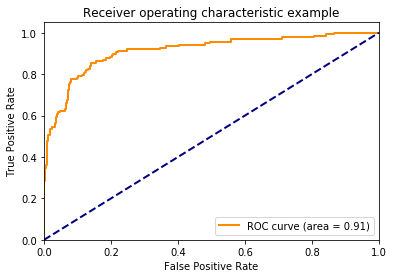

<Figure size 432x288 with 0 Axes>

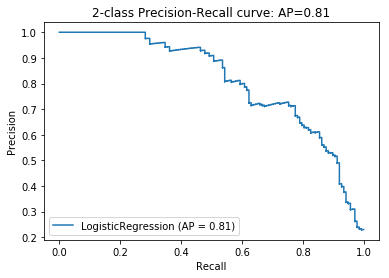

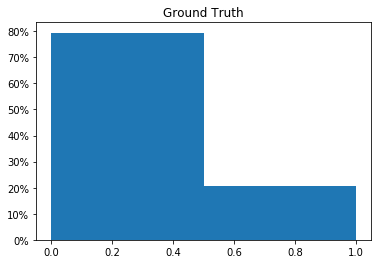

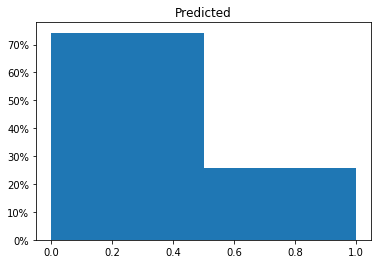

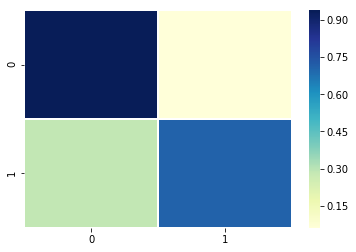

In [120]:
# test model
predY = clf.predict_proba(testX)[:, 1]
print("Test Score:", np.round(clf.score(testX, testY_mod), 4))

# get auc
auc = roc_auc_score(testY_mod, predY)
print("AUC:", np.round(auc, 4))

# plot roc curve
fpr, tpr, roc_thresholds = roc_curve(testY_mod, predY)
precision, recall, thresholds = precision_recall_curve(testY_mod, predY)

# optimize for precision and recall
best_pr_thresh = np.argmax(np.square(precision) + np.square(recall))

# find corresponding threshold index for roc curve (thresholds are reverse order)
# roc_thresh = int(roc_thresholds.shape[0] * (1 - best_pr_thresh / thresholds.shape[0]))
roc_thresh = np.argmax(np.square(tpr) + np.square(1 - fpr))
#print('roc thresh:', roc_thresholds.shape)
#print('pr thresh:', thresholds.shape)

print("Sensitivity: " + str(np.round(tpr[roc_thresh], 4)))
print("Specificity: " + str(np.round(1 - fpr[roc_thresh], 4)))
print("Precision: " + str(np.round(precision[best_pr_thresh], 4)))
print("Recall: " + str(np.round(recall[best_pr_thresh], 4)))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

plt.figure()
average_precision = average_precision_score(testY_mod, predY)
disp = plot_precision_recall_curve(clf, testX, testY_mod)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
plt.show()
# class balance
plt.hist(testY_mod, bins=2, weights=np.ones(len(testY_mod)) / len(testY_mod))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Ground Truth")
plt.show()

plt.hist(predY, bins=2, weights=np.ones(len(predY)) / len(predY))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Predicted")
plt.show()

# heatmap
predY = predY > thresholds[best_pr_thresh]
confusion = confusion_matrix(predY, testY_mod)
confusion = confusion / np.sum(confusion, axis=1)[:, None]
heatmap = sns.heatmap(confusion, linewidths=.5, cmap="YlGnBu")

# Combining mortality and GCS

In [53]:
# Splitting into three categories:
# 1. dead
# 2. alive with deficits (GCS < 6)
# 3. alive without deficits (GCS = 6)

# final_gcs_id = gcs.groupby('patientunitstayid')['observationoffset'].transform(max) == gcs['observationoffset']
# final_gcs = gcs[final_gcs_id]

# Combining the final_GCS information and mortality
print(final_gcs.shape)
# final_gcs.head()
print(died.shape)
died.head()

(2608, 5)
(5397, 3)


,patientunitstayid,unitdischargestatus,alive
0,2896749,Alive,True
1,976143,Alive,True
2,1823818,Alive,True
3,2715079,Alive,True
4,1015921,Alive,True


In [54]:
# First extracting ids that will be used
id_df.head()
final_gcs_finalids = final_gcs.merge(id_df, on='patientunitstayid', how='right')
died_finalids = died.merge(id_df, on='patientunitstayid', how='right')
print(final_gcs_finalids.shape)
print(np.isnan(final_gcs_finalids['Value']).any())
print(died_finalids.shape)
print(np.isnan(died_finalids['alive']).any())

# Merging the final_gcs_finalids and died_finalids based on patientunitstayid
gcs_mortality_comb = final_gcs_finalids.merge(died_finalids, on='patientunitstayid')[['patientunitstayid','Value','alive']]
gcs_mortality_comb.rename(columns={'Value':'final_gcs'}, inplace=True)

(2248, 5)
False
(2248, 3)
False


In [55]:
gcs_mortality_comb.head()

,patientunitstayid,final_gcs,alive
0,172448,1.0,False
1,242714,6.0,True
2,242825,6.0,True
3,243176,6.0,True
4,243493,6.0,True


In [56]:
# Categorizing each patient as one of three classes
# (dead, alive with GCS<6, alive with GCS=6)
dead = gcs_mortality_comb[gcs_mortality_comb['alive'] == False]
alive = gcs_mortality_comb[gcs_mortality_comb['alive'] == True]
alive_deficit = alive[alive['final_gcs'] != 6.0]
alive_nodeficit = alive[alive['final_gcs'] == 6.0]
print(dead.shape)
print(alive.shape)
print(alive_deficit.shape)
print(alive_nodeficit.shape)
# dead.head()

# Adding column to each df corresponding to class
# 0: dead, 1: alive with deficit, 2: alive without deficit
dead['class'] = np.zeros((dead.shape[0], 1), dtype=int)
alive_deficit['class'] = np.ones((alive_deficit.shape[0], 1), dtype=int)
alive_nodeficit['class'] = np.ones((alive_nodeficit.shape[0], 1), dtype=int)*2

# Unioning the three dataframes
gcs_mortality_class = pd.concat([dead, alive_deficit, alive_nodeficit])
print(gcs_mortality_class.shape)
gcs_mortality_class.head()

(201, 3)
(2047, 3)
(291, 3)
(1756, 3)
(2248, 4)


C:\Users\owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

,patientunitstayid,final_gcs,alive,class
0,172448,1.0,False,0
28,268706,1.0,False,0
32,272480,1.0,False,0
47,284630,1.0,False,0
53,286955,2.0,False,0


In [57]:
# Reordering the rows to match other data sources
gcs_mortality_labels = np.hstack([gcs_mortality_class.loc[gcs_mortality_class['patientunitstayid'] == g]['class'].values[:,None] for g in keys])[0]

In [58]:
mort = True
scaler = StandardScaler()
raw_pca = PCA(n_components = 10)
raw_pca.fit(X_gcs)
X_gcs_pca = raw_pca.transform(scaler.fit_transform(X_gcs))

pca_time = True
if pca_time:
    raw_pca = PCA(n_components = 5)
    raw_pca.fit(X_hr)
    X_hr_pca = raw_pca.transform(scaler.fit_transform(X_hr))
    raw_pca.fit(X_resp)
    X_resp_pca = raw_pca.transform(scaler.fit_transform(X_resp))
    raw_pca.fit(X_sao2)
    X_sao2_pca = raw_pca.transform(scaler.fit_transform(X_sao2))   

else:
    X_hr_pca = np.hstack([np.mean(X_hr, axis = 1)[:, np.newaxis], np.std(X_hr, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis],
                      np.std(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis]])

    X_resp_pca = np.hstack([np.mean(X_resp, axis = 1)[:, np.newaxis], np.std(X_resp, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis],
                      np.std(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis]])

    X_sao2_pca = np.hstack([np.mean(X_sao2, axis = 1)[:, np.newaxis], np.std(X_sao2, axis = 1)[:, np.newaxis],
                      np.mean(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis],
                      np.mean(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis],
                        np.std(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis]])

X_phys = np.hstack([X_hr_pca, X_resp_pca, X_sao2_pca, X_gcs_pca])
X_phys = scaler.fit_transform(X_phys)

X_labdem = np.hstack([X_labavgs, X_labcts, X_dem])
scaler.fit(X_labdem)
X_labdem = scaler.transform(X_labdem)

X_naive = np.hstack([X_phys, X_labdem])
target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
        None] for g in keys])

# split data
trainX, testX, trainY, testY = train_test_split(X_naive, gcs_mortality_labels, test_size=0.3, random_state = 8055)
trainY, testY = trainY.flatten(), testY.flatten()

# resample
if resampling == 'over':
    if mort:
        positive = np.argwhere(trainY.flatten() == False).flatten()
        negative = np.argwhere(trainY.flatten() == True).flatten()
    else:
        positive = np.argwhere(trainY.flatten() < 6).flatten()
        negative = np.argwhere(trainY.flatten() == 6).flatten()
    
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_positive = resample(X_positive, replace=True, n_samples=X_negative.shape[0], random_state = 8055)
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]

elif resampling == 'under':
    if mort:
        positive = np.argwhere(trainY.flatten() == False).flatten()
        negative = np.argwhere(trainY.flatten() == True).flatten()
    else:
        positive = np.argwhere(trainY.flatten() < 6).flatten()
        negative = np.argwhere(trainY.flatten() == 6).flatten()
        
    X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
    X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])
    
    X_negative = resample(X_negative, replace=False, n_samples=X_positive.shape[0], random_state = 8055)
    stacked = np.vstack([X_positive, X_negative])
    np.random.shuffle(stacked)
        
    trainX = stacked[:, :-1]
    trainY = stacked[:, -1]

ValueError: Found input variables with inconsistent numbers of samples: [2238, 2248]

In [ ]:
# modify labels
testY_mod = testY
trainY_mod = trainY
    
# train model
model_family = 'logistic'
if model_family == 'logistic':
    clf = LogisticRegression(max_iter=2000, penalty='elasticnet', l1_ratio=0.5,
                         solver='saga', C=.8)
    
elif model_family == 'random_forest':
    clf = RandomForestClassifier(max_depth=2, n_estimators=10)

print(trainX.shape)
clf.fit(trainX, trainY_mod)
print("Train Score:", clf.score(trainX, trainY_mod))

# Bootstrapping

In [38]:
stats=pd.DataFrame(columns=['Train Score', 'Test Score', 'AUC', 'bestThreshInd1',  'bestThreshInd',
                            'Precision','Recall'])
roc_data=[]
thetas=pd.DataFrame()
betas=[]
tr_acc=[]
test_acc=[]

mort = False

for run in range(10):
    # split data
    if mort:
        trainX, testX, trainY, testY = train_test_split(X_naive, deathstatus, test_size=0.3, random_state = 8055)
        trainY, testY = trainY.flatten(), testY.flatten()
    else:
        trainX, testX, trainY, testY = train_test_split(X_naive, target_gcs, test_size=0.3, random_state = 8055)
        trainY, testY = trainY.flatten(), testY.flatten()

    # resample
    if resampling == 'over':
        if mort:
            positive = np.argwhere(trainY.flatten() == False).flatten()
            negative = np.argwhere(trainY.flatten() == True).flatten()
        else:
            positive = np.argwhere(trainY.flatten() < 6).flatten()
            negative = np.argwhere(trainY.flatten() == 6).flatten()

        X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
        X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])

        X_positive = resample(X_positive, replace=True, n_samples=X_negative.shape[0], random_state = 8055)
        stacked = np.vstack([X_positive, X_negative])
        np.random.shuffle(stacked)

        trainX = stacked[:, :-1]
        trainY = stacked[:, -1]

    elif resampling == 'under':
        if mort:
            positive = np.argwhere(trainY.flatten() == False).flatten()
            negative = np.argwhere(trainY.flatten() == True).flatten()
        else:
            positive = np.argwhere(trainY.flatten() < 6).flatten()
            negative = np.argwhere(trainY.flatten() == 6).flatten()

        X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
        X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])

        X_negative = resample(X_negative, replace=False, n_samples=X_positive.shape[0], random_state = 8055)
        stacked = np.vstack([X_positive, X_negative])
        np.random.shuffle(stacked)

        trainX = stacked[:, :-1]
        trainY = stacked[:, -1]
    
    # modify labels
    if mort:
        testY_mod = testY.astype(int)
    
        trainY_mod = trainY.astype(int)

    else:
        testY_mod = testY.copy()
        testY_mod[testY < 6] = 1
        testY_mod[testY == 6] = 0

        trainY_mod = trainY.copy()
        trainY_mod[trainY < 6] = 1
        trainY_mod[trainY == 6] = 0

    # train feature-selector
    clf = LogisticRegression(max_iter=2000, penalty='l1', l1_ratio=0.5,
                             solver='saga', C=.05)

    clf.fit(trainX, trainY_mod)

    lasso_coeff = clf.coef_[0]
    lasso_indices = [x[0] for x in np.argwhere(clf.coef_[0] != 0).tolist()]
    X_med_infusion_selected = X_labdem[:,lasso_indices]

    # getting column names
    med_inf_colnames = list(medication_allids.columns) + list(infusion_allids.columns)

    if (not mort) and (discard_dead):
        # Removing the patients who have GCS = 6 and died
        newkeys = []
        for k in keys:
            if k not in died_gcs6_ids:
                newkeys.append(k)

        target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
                None] for g in newkeys])

            # now stack data based on the same patient order
        X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
                None] for g in newkeys])

        X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
                None] for g in newkeys])

        X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
                None] for g in newkeys])

        X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
                None] for g in newkeys])

        X_hr = X_hr.T
        X_resp = X_resp.T
        X_sao2 = X_sao2.T
        X_gcs = X_gcs.T

        labavg_cols = []
        for c in labtypedata_avgs_allids.columns:
            if c != 'patientunitstayid':
                labavg_cols.append(c)
        X_labavgs = np.hstack([labtypedata_avgs_allids.loc[labtypedata_avgs_allids['patientunitstayid'] == g][labavg_cols].values[:,
                None] for g in newkeys])[0]

        labcts_cols = []
        for c in labtypedata_cts_allids.columns:
            if c != 'patientunitstayid':
                labcts_cols.append(c)
        X_labcts = np.hstack([labtypedata_cts_allids.loc[labtypedata_cts_allids['patientunitstayid'] == g][labcts_cols].values[:,
                None] for g in newkeys])[0]

        dem_cols = []
        for c in dem_allids.columns:
            if c != 'patientunitstayid':
                dem_cols.append(c)
        X_dem = np.hstack([dem_allids.loc[dem_allids['patientunitstayid'] == g][dem_cols].values[:,None] for g in newkeys])[0]

        medication_cols = []
        for c in medication_allids.columns:
            if c != 'patientunitstayid':
                medication_cols.append(c)
        X_med = np.hstack([medication_allids.loc[medication_allids['patientunitstayid'] == g][medication_cols].values[:,None] for g in newkeys])[0]

        infusion_cols = []
        for c in infusion_allids.columns:
            if c != 'patientunitstayid':
                infusion_cols.append(c)
        X_infusion = np.hstack([infusion_allids.loc[infusion_allids['patientunitstayid'] == g][infusion_cols].values[:,None] for g in newkeys])[0]

    else:
            # now stack data based on the same patient order
        X_hr = np.hstack([hr_first24.loc[hr_first24['patientunitstayid'] == g]['value'].values[:,
                None] for g in keys])

        X_resp = np.hstack([resp_first24.loc[resp_first24['patientunitstayid'] == g]['value'].values[:,
                None] for g in keys])

        X_sao2 = np.hstack([sao2_first24.loc[sao2_first24['patientunitstayid'] == g]['value'].values[:,
                None] for g in keys])

        X_gcs = np.hstack([gcs_first24.loc[gcs_first24['patientunitstayid'] == g]['value'].values[:,
                None] for g in keys])

        X_hr = X_hr.T
        X_resp = X_resp.T
        X_sao2 = X_sao2.T
        X_gcs = X_gcs.T

        labavg_cols = []
        for c in labtypedata_avgs_allids.columns:
            if c != 'patientunitstayid':
                labavg_cols.append(c)
        X_labavgs = np.hstack([labtypedata_avgs_allids.loc[labtypedata_avgs_allids['patientunitstayid'] == g][labavg_cols].values[:,
                None] for g in keys])[0]

        labcts_cols = []
        for c in labtypedata_cts_allids.columns:
            if c != 'patientunitstayid':
                labcts_cols.append(c)
        X_labcts = np.hstack([labtypedata_cts_allids.loc[labtypedata_cts_allids['patientunitstayid'] == g][labcts_cols].values[:,
                None] for g in keys])[0]

        dem_cols = []
        for c in dem_allids.columns:
            if c != 'patientunitstayid':
                dem_cols.append(c)
        X_dem = np.hstack([dem_allids.loc[dem_allids['patientunitstayid'] == g][dem_cols].values[:,None] for g in keys])[0]

        medication_cols = []
        for c in medication_allids.columns:
            if c != 'patientunitstayid':
                medication_cols.append(c)
        X_med = np.hstack([medication_allids.loc[medication_allids['patientunitstayid'] == g][medication_cols].values[:,None] for g in keys])[0]

        infusion_cols = []
        for c in infusion_allids.columns:
            if c != 'patientunitstayid':
                infusion_cols.append(c)
        X_infusion = np.hstack([infusion_allids.loc[infusion_allids['patientunitstayid'] == g][infusion_cols].values[:,None] for g in keys])[0]

        target_gcs = np.vstack([final_gcs.loc[final_gcs['patientunitstayid'] == g]['Value'].values[:,
                None] for g in keys])

    scaler = StandardScaler()
    raw_pca = PCA(n_components = 10)
    raw_pca.fit(X_gcs)
    X_gcs_pca = raw_pca.transform(scaler.fit_transform(X_gcs))

    scaler = StandardScaler()
    raw_pca = PCA(n_components = 10)
    raw_pca.fit(X_med)
    X_med_pca = raw_pca.transform(scaler.fit_transform(X_med))

    scaler = StandardScaler()
    raw_pca = PCA(n_components = 10)
    raw_pca.fit(X_infusion)
    X_infusion_pca = raw_pca.transform(scaler.fit_transform(X_infusion))

    pca_time = True
    if pca_time:
        raw_pca = PCA(n_components = 5)
        raw_pca.fit(X_hr)
        X_hr_pca = raw_pca.transform(scaler.fit_transform(X_hr))
        raw_pca.fit(X_resp)
        X_resp_pca = raw_pca.transform(scaler.fit_transform(X_resp))
        raw_pca.fit(X_sao2)
        X_sao2_pca = raw_pca.transform(scaler.fit_transform(X_sao2))

    else:
        X_hr_pca = np.hstack([np.mean(X_hr, axis = 1)[:, np.newaxis], np.std(X_hr, axis = 1)[:, np.newaxis],
                          np.mean(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_hr, axis = 1), axis = 1)[:, np.newaxis],
                          np.mean(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis],
                          np.std(np.diff(np.diff(X_hr, axis = 1)), axis = 1)[:, np.newaxis]])

        X_resp_pca = np.hstack([np.mean(X_resp, axis = 1)[:, np.newaxis], np.std(X_resp, axis = 1)[:, np.newaxis],
                          np.mean(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_resp, axis = 1), axis = 1)[:, np.newaxis],
                          np.mean(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis],
                          np.std(np.diff(np.diff(X_resp, axis = 1)), axis = 1)[:, np.newaxis]])

        X_sao2_pca = np.hstack([np.mean(X_sao2, axis = 1)[:, np.newaxis], np.std(X_sao2, axis = 1)[:, np.newaxis],
                          np.mean(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis], np.std(np.diff(X_sao2, axis = 1), axis = 1)[:, np.newaxis],
                          np.mean(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis],
                            np.std(np.diff(np.diff(X_sao2, axis = 1)), axis = 1)[:, np.newaxis]])

    X_phys = np.hstack([X_hr_pca, X_resp_pca, X_sao2_pca, X_gcs_pca])
    X_phys = scaler.fit_transform(X_phys)

    X_labdem = np.hstack([X_labavgs, X_labcts, X_dem, X_med_infusion_selected])
    scaler.fit(X_labdem)
    X_labdem = scaler.transform(X_labdem)
    X_naive = np.hstack([X_phys, X_labdem])

    # split data
    if mort:
        trainX, testX, trainY, testY = train_test_split(X_naive, deathstatus, test_size=0.3, random_state = 8055)
        trainY, testY = trainY.flatten(), testY.flatten()
    else:
        trainX, testX, trainY, testY = train_test_split(X_naive, target_gcs, test_size=0.3, random_state = 8055)
        trainY, testY = trainY.flatten(), testY.flatten()

    # resample
    if resampling == 'over':
        if mort:
            positive = np.argwhere(trainY.flatten() == False).flatten()
            negative = np.argwhere(trainY.flatten() == True).flatten()
        else:
            positive = np.argwhere(trainY.flatten() < 6).flatten()
            negative = np.argwhere(trainY.flatten() == 6).flatten()

        X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
        X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])

        X_positive = resample(X_positive, replace=True, n_samples=X_negative.shape[0], random_state = 8055)
        stacked = np.vstack([X_positive, X_negative])
        np.random.shuffle(stacked)

        trainX = stacked[:, :-1]
        trainY = stacked[:, -1]

    elif resampling == 'under':
        if mort:
            positive = np.argwhere(trainY.flatten() == False).flatten()
            negative = np.argwhere(trainY.flatten() == True).flatten()
        else:
            positive = np.argwhere(trainY.flatten() < 6).flatten()
            negative = np.argwhere(trainY.flatten() == 6).flatten()

        X_positive = np.hstack([trainX[positive], trainY[positive][:, None]])
        X_negative = np.hstack([trainX[negative], trainY[negative][:, None]])

        X_negative = resample(X_negative, replace=False, n_samples=X_positive.shape[0], random_state = 8055)
        stacked = np.vstack([X_positive, X_negative])
        np.random.shuffle(stacked)

        trainX = stacked[:, :-1]
        trainY = stacked[:, -1]

    # modify labels
    if mort:
        testY_mod = testY.astype(int)
        trainY_mod = trainY.astype(int)

    else:
        testY_mod = testY.copy()
        testY_mod[testY < 6] = 1
        testY_mod[testY == 6] = 0

        trainY_mod = trainY.copy()
        trainY_mod[trainY < 6] = 1
        trainY_mod[trainY == 6] = 0

    # train model
    model_family = 'logistic'
    if model_family == 'logistic':
        clf = LogisticRegression(max_iter=2000, penalty='elasticnet', l1_ratio=0.5,
                             solver='saga', C=0.5)

    elif model_family == 'random_forest':
        clf = RandomForestClassifier(max_depth=2, n_estimators=10)

    clf.fit(trainX, trainY_mod)

    # test model
    predY = clf.predict_proba(testX)[:, 1]

    # get auc
    auc = roc_auc_score(testY_mod, predY)

    # plot roc curve
    fpr, tpr, roc_thresholds = roc_curve(testY_mod, predY)
    precision, recall, thresholds = precision_recall_curve(testY_mod, predY)

    # optimize for precision and recall
    best_pr_thresh = np.argmax(np.square(precision) + np.square(recall))

    # find best roc thresh
    best_roc_thresh = np.argmax(np.square(tpr) + np.square(1-fpr))
    
    
    
roc_data.append(np.vstack([roc_thresholds, fpr, tpr]))
stats=stats.append({'Train Score': train_score, 'Test Score': test_score, 'AUC': auc, 
                        'Theta Star':thresholds_1[bestThreshInd1],
                        'Precision': prec, 'Recall':reca}, ignore_index=True)


NameError: name 'X_naive' is not defined